In [1]:
import dLux as dl
import dLuxToliman as dlT
import matplotlib.pyplot as plt

In [2]:
optics = dlT.TolimanOpticalSystem(oversample=4)
source = dlT.AlphaCen()

telescope = dl.Telescope(optics, source)

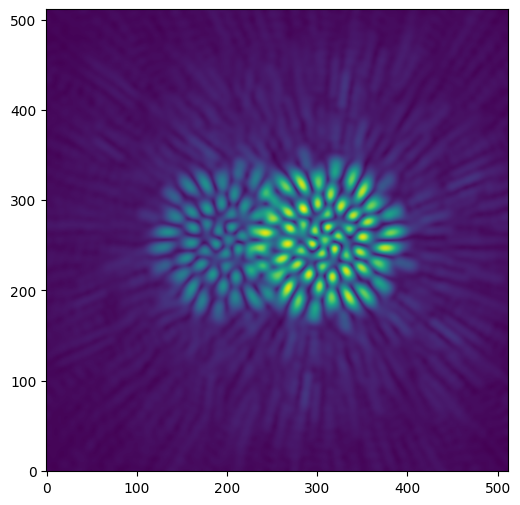

In [3]:
plt.figure(figsize=(6,6))
plt.imshow(telescope.model()**0.5, origin='lower')
#plt.savefig('pupilfig.pdf')
plt.show()

In [4]:
import jax.numpy as np
coords = dl.utils.pixel_coords(512, 0.125)

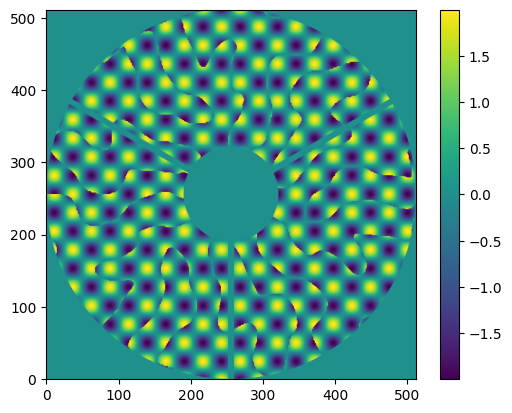

In [5]:
a = 500
grate = np.sin((coords[0]+coords[1])*a) + np.sin((coords[0] - coords[1])*a)
phase = dlT.TolimanPupilLayer(512).phase

grate *=  (phase/np.max(phase)*2 - 1) * dlT.TolimanApertureLayer(512).transmission

#plt.imshow(phase)
plt.imshow(grate, origin='lower')
plt.colorbar()
plt.show()

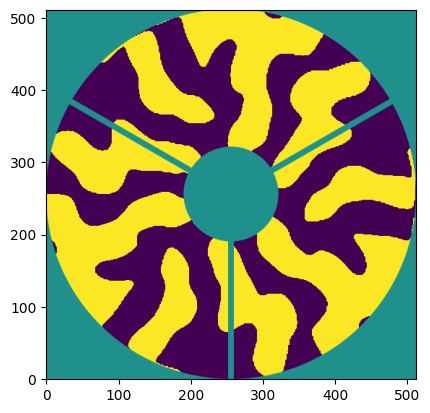

In [6]:
plt.imshow((phase/np.max(phase)*2 - 1) * dlT.TolimanApertureLayer(512).transmission, origin='lower')

In [7]:
a = 1000
grate = np.sin((coords[0]+coords[1])*a) + np.sin((coords[0] - coords[1])*a)
phase = dlT.TolimanPupilLayer(512).phase

grate *=  dlT.TolimanApertureLayer(512).transmission * (phase/np.max(phase)*2 - 1)

grating_layer = dl.AberratedLayer(phase = 1.1*grate)

layers_new = [
    (
        'aperture',
        dlT.TolimanApertureLayer(512)
    ),
    # (
    #     'pupil',
    #     dlT.TolimanPupilLayer(512)
    # ),
    (
        'grating',
        grating_layer
    )
]

optics_new = dl.AngularOpticalSystem(512, 0.125, layers_new, 400, 0.375, 8)
source_new = dl.PointSource(np.array([585e-9]))
telescope_new = dl.Telescope(optics_new, source_new)

In [8]:
print(np.max(1.1*grate)-np.min(1.1*grate))

4.3998837


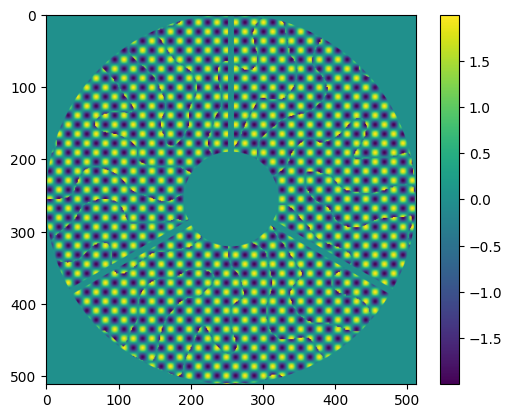

In [9]:
plt.imshow(grate)
plt.colorbar()

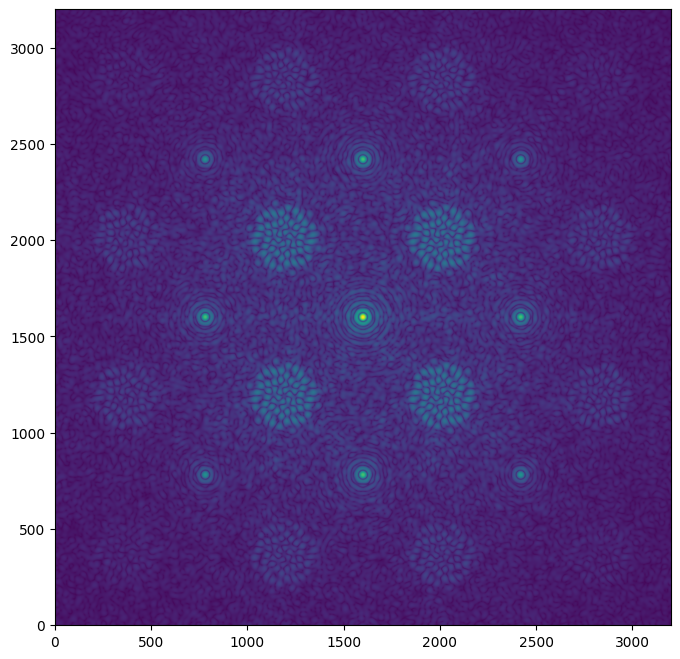

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(telescope_new.model()**0.2, origin='lower')
plt.show()

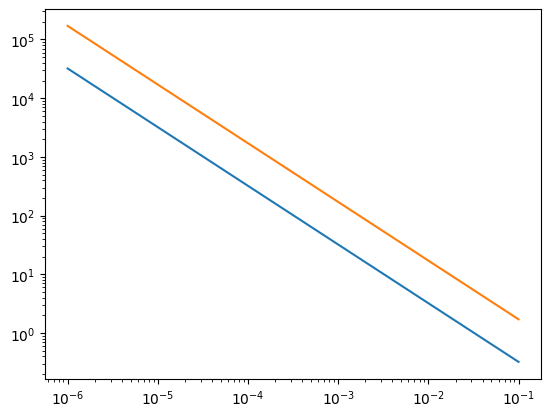

In [11]:
import dLux.utils as dlu

delta_lambda = 110e-9
centre_lambda = 585e-9

periods = np.logspace(-6, -1, 1000)
delta_x = dlu.rad2arcsec(np.sqrt(2)/periods * delta_lambda)
centre_x = dlu.rad2arcsec(np.sqrt(2)/periods * centre_lambda)


plt.plot(periods, delta_x)
plt.plot(periods, centre_x)
plt.xscale('log')
plt.yscale('log')
plt.show()

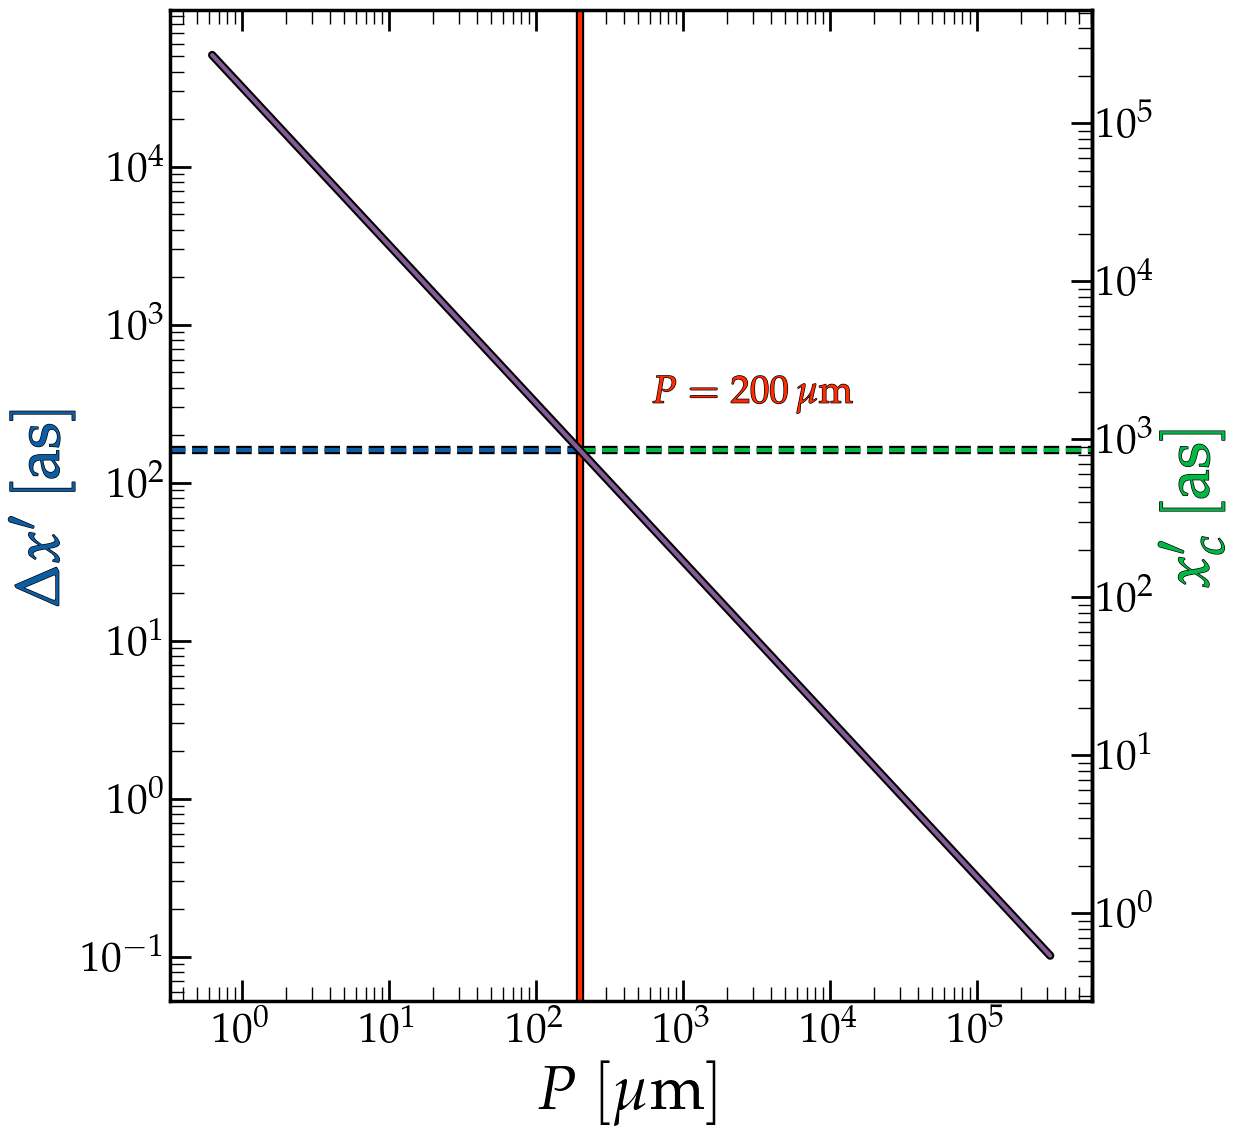

In [ ]:
import matplotlib.ticker as ticker
import dLux.utils as dlu
from matplotlib.ticker import FuncFormatter

plt.style.use('../wk17/sty.mplstyle')

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

delta_lambda = 110e-9
centre_lambda = 585e-9

periods = np.logspace(-6.2, -0.5, 1000)
delta_x = dlu.rad2arcsec(np.sqrt(2)/periods * delta_lambda)
# centre_x is just delta_x * ratio
ratio = centre_lambda / delta_lambda

fig, ax = plt.subplots(figsize=(13,12))

ax.axvline(200, color='C3',ls='-',path_effects=path_effects)#,ymax=0.50)
#ax.axvline(200, color='C3',ls='-',path_effects=path_effects,ymin=0.61)

ax.axhline(dlu.rad2arcsec(np.sqrt(2)/(200e-6) * delta_lambda), xmax=0.445, color='C0', ls='--', path_effects=path_effects)

ax.axhline(dlu.rad2arcsec(np.sqrt(2)/(200e-6) * delta_lambda), xmin=0.445, color='C1', ls='--', path_effects=path_effects)

# plot only once (left axis values)
ax.plot(1e6*periods, delta_x, color='C4', path_effects=path_effects)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$P$ $[\mu \mathrm{m}]$')
ax.set_ylabel(r"$\Delta x'$ $[\mathrm{as}]$", color='C0',path_effects=text_path_effects)

# PRIMARY axis: ensure ticks only appear on the LEFT
ax.yaxis.set_ticks_position('left')               # tick marks placed on left
ax.tick_params(axis='y', which='both', right=False, labelright=False)

# Add a secondary right-hand y-axis that is simply left_y * ratio
def to_centre(y):     # maps left->right
    return y * ratio

def from_centre(y):   # maps right->left (inverse)
    return y / ratio

sec = ax.secondary_yaxis('right', functions=(to_centre, from_centre))
sec.set_ylabel(r"$x_c'$ $[\mathrm{as}]$", color='C1',path_effects=text_path_effects)

# --- draw a circular marker around the P=200um point (hollow circle in screen coords) ---
# ax.scatter(200, dlu.rad2arcsec(np.sqrt(2)/(200e-6) * delta_lambda),
#            s=6000,                 # marker area in points^2 (tweak this)
#            facecolors='none',     # hollow circle
#            edgecolors='C3',
#            linewidth=3,
#            zorder=10,
#            path_effects=path_effects)

# Add a label with an arrow
ax.annotate(r'$P=200\,\mu\mathrm{m}$',
            xy=(200, dlu.rad2arcsec(np.sqrt(2)/(200e-6) * delta_lambda)),
            xytext=(200*15, dlu.rad2arcsec(np.sqrt(2)/(200e-6) * delta_lambda)*2),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)

plt.tight_layout()
#plt.savefig('period_position.pdf',dpi=300,bbox_inches='tight')
plt.show()


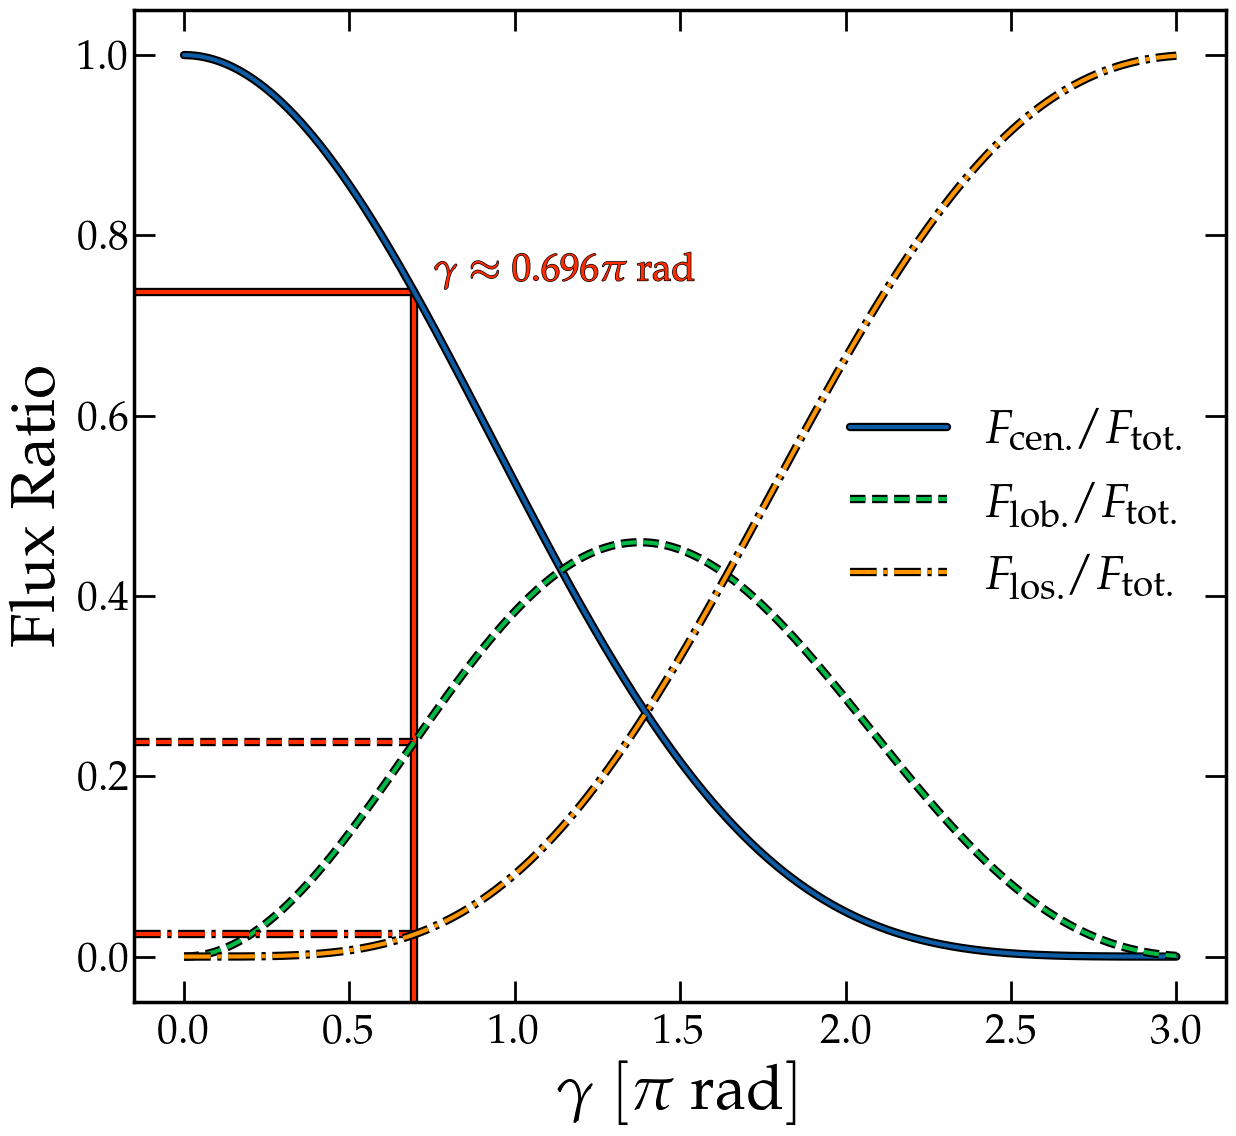

In [21]:
# flux figure
from jax.scipy.special import j1, j0
import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

pp_phase = np.linspace(0,3*np.pi,1000)
F_cen = j0(pp_phase/4)**4
F_lob = 4*j0(pp_phase/4)**2 * j1(pp_phase/4)**2
F_los = 1 - (F_cen + F_lob)

plt.axvline(0.348*2,color='C3',ls='-',path_effects=path_effects,ymax=0.715)

plt.axhline(j0(0.348*2*np.pi/4)**4, color='C3', xmax=0.255,path_effects=path_effects)
plt.plot(pp_phase/np.pi, F_cen, label=r'$F_{\mathrm{cen.}}/F_{\mathrm{tot.}}$', path_effects=path_effects)

plt.axhline(4*j0(0.348*2*np.pi/4)**2 * j1(0.348*2*np.pi/4)**2, color='C3', xmax=0.255,path_effects=path_effects, ls='--')
plt.plot(pp_phase/np.pi, F_lob, label=r'$F_{\mathrm{lob.}}/F_{\mathrm{tot.}}$', path_effects=path_effects, ls='--')

plt.axhline(1-(j0(0.348*2*np.pi/4)**4+4*j0(0.348*2*np.pi/4)**2 * j1(0.348*2*np.pi/4)**2), color='C3', xmax=0.255,path_effects=path_effects, ls='-.')
plt.plot(pp_phase/np.pi, F_los, label=r'$F_{\mathrm{los.}}/F_{\mathrm{tot.}}$', path_effects=path_effects, ls='-.')
plt.xlabel(r'$\gamma$ $[\pi \ \mathrm{rad}]$')
plt.ylabel('Flux Ratio')

plt.annotate(r'$\gamma \approx 0.696\pi \ \mathrm{rad}$',
            xy=(1.15, 0.75), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)

plt.legend()
plt.tight_layout()
#plt.savefig('fluxfig.pdf',dpi=300,bbox_inches='tight')
plt.show()

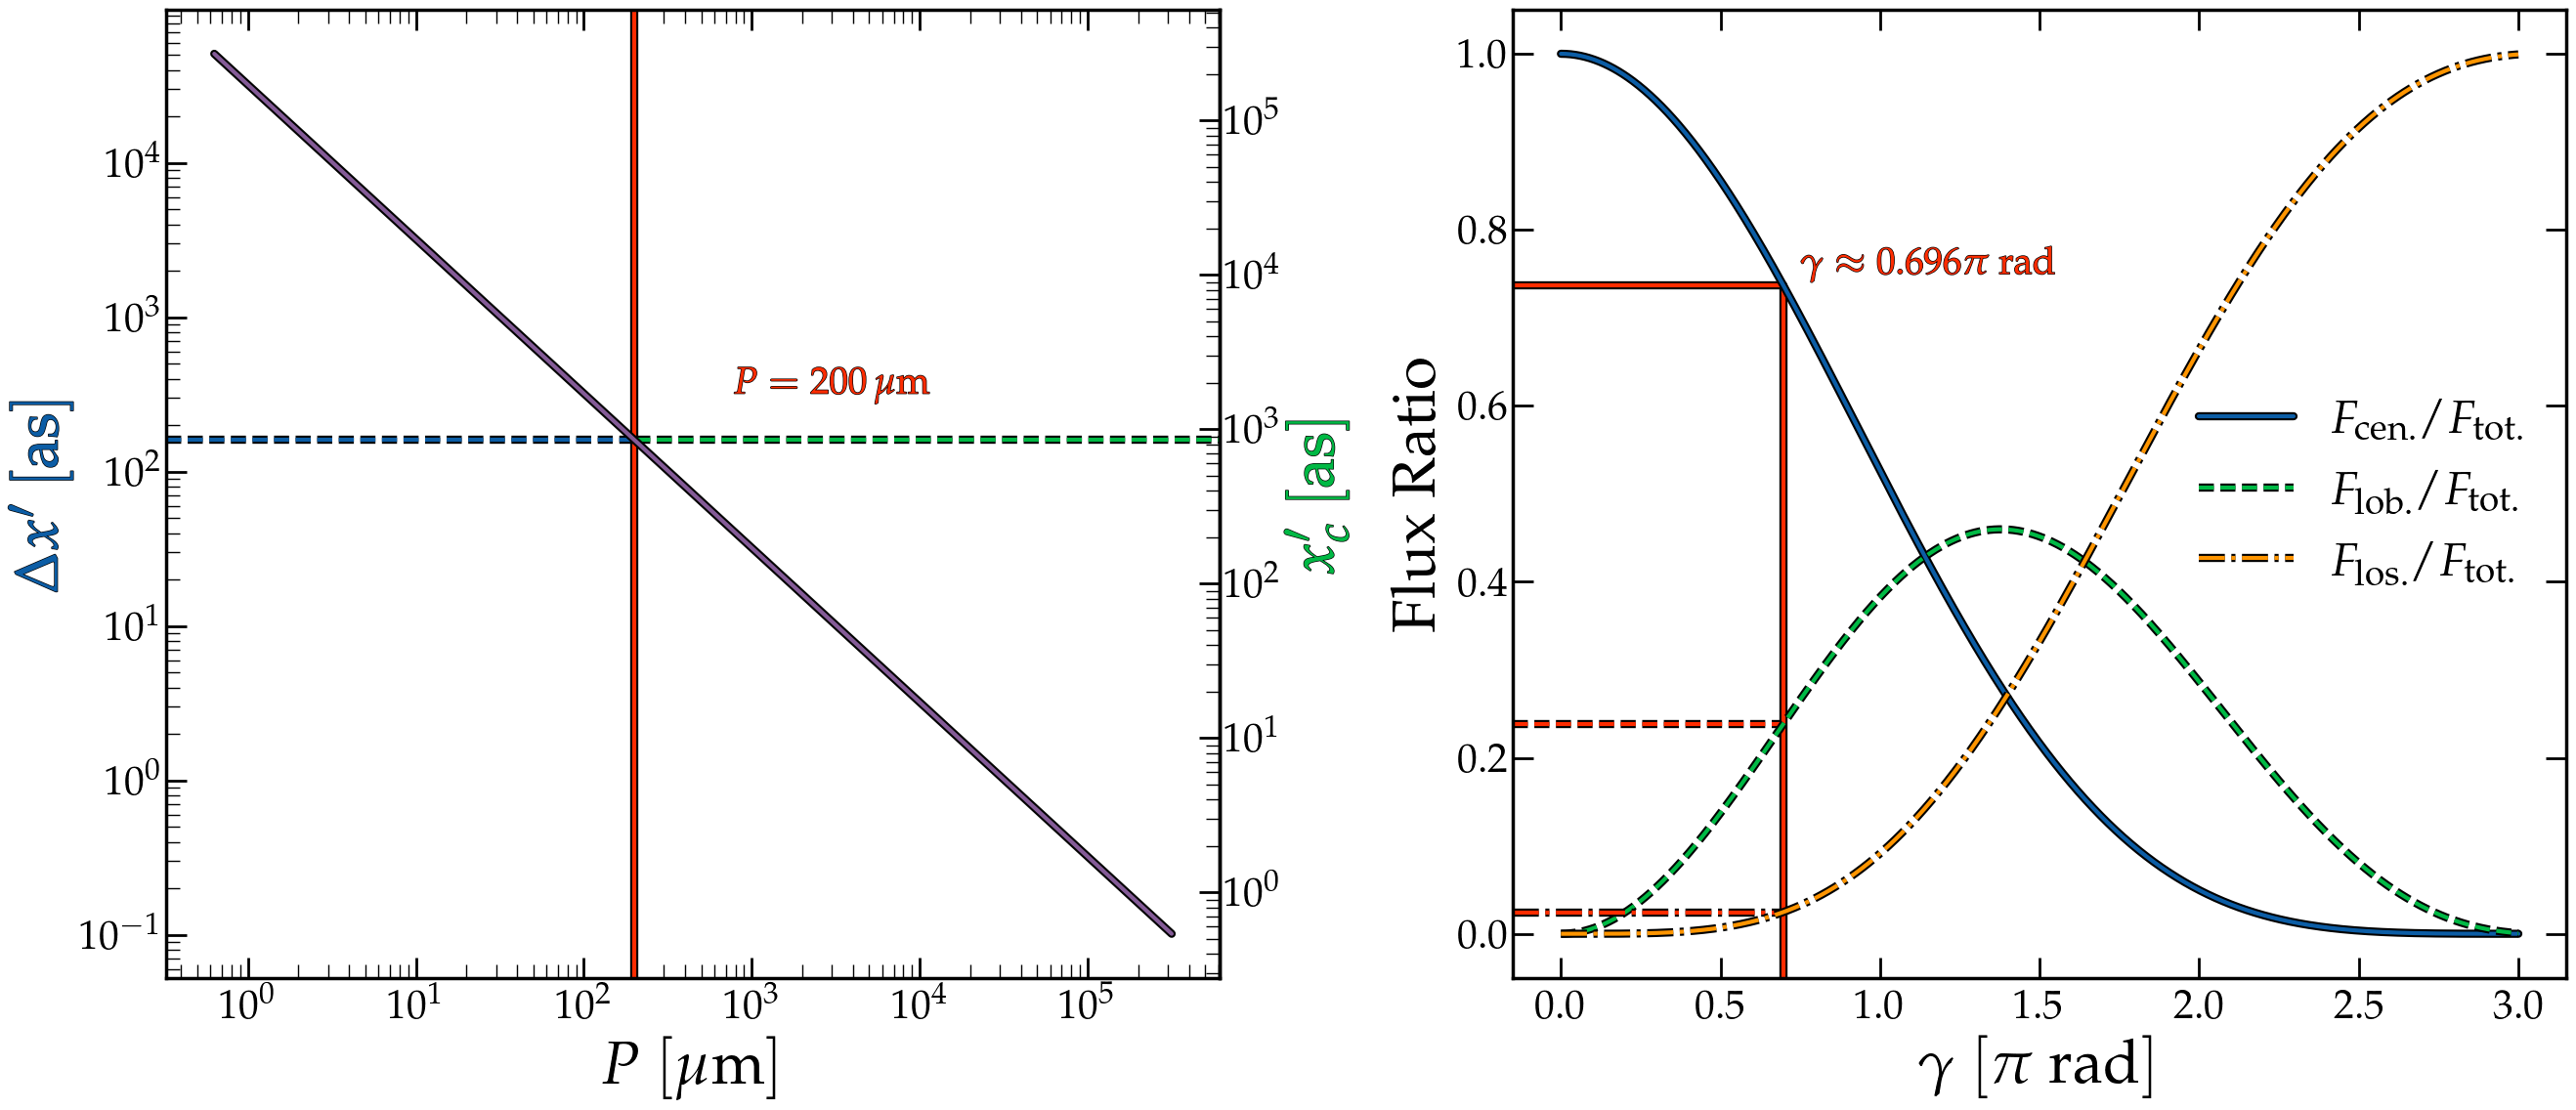

In [29]:
# combining two figures

# --- shared path effects ---
text_path_effects = [pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

# =========================
# Data/constants for LEFT panel
# =========================
delta_lambda = 110e-9
centre_lambda = 585e-9
periods = np.logspace(-6.2, -0.5, 1000)          # [m]
delta_x = dlu.rad2arcsec(np.sqrt(2)/periods * delta_lambda)
ratio = centre_lambda / delta_lambda

# =========================
# Data for RIGHT panel
# =========================
pp_phase = np.linspace(0, 3*np.pi, 1000)
F_cen = j0(pp_phase/4)**4
F_lob = 4*j0(pp_phase/4)**2 * j1(pp_phase/4)**2
F_los = 1 - (F_cen + F_lob)

# =========================
# Figure + Axes
# =========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(27, 12))

# -------------------------
# LEFT: Period ↔ position
# -------------------------
ax1.axvline(200, color='C3', ls='-', path_effects=path_effects)

y_at_200 = dlu.rad2arcsec(np.sqrt(2)/(200e-6) * delta_lambda)
# split the horizontal guideline into left/right color segments
ax1.axhline(y_at_200, xmax=0.445, color='C0', ls='--', path_effects=path_effects)
ax1.axhline(y_at_200, xmin=0.445, color='C1', ls='--', path_effects=path_effects)

# main curve
ax1.plot(1e6*periods, delta_x, color='C4', path_effects=path_effects)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$P$ $[\mu \mathrm{m}]$')
ax1.set_ylabel(r"$\Delta x'$ $[\mathrm{as}]$", color='C0', path_effects=text_path_effects)

# ticks only on LEFT
ax1.yaxis.set_ticks_position('left')
ax1.tick_params(axis='y', which='both', right=False, labelright=False)

# secondary y-axis: x_c' = ratio * Δx'
def to_centre(y):
    return y * ratio
def from_centre(y):
    return y / ratio

sec = ax1.secondary_yaxis('right', functions=(to_centre, from_centre))
sec.set_ylabel(r"$x_c'$ $[\mathrm{as}]$", color='C1', path_effects=text_path_effects)

# annotation
ax1.annotate(r'$P=200\,\mu\mathrm{m}$',
             xy=(200, y_at_200),
             xytext=(200*15, y_at_200*2),
             color='C3',
             ha='center',
             path_effects=text_path_effects)

# -------------------------
# RIGHT: Flux ratios vs phase
# -------------------------
# vertical guide at γ ≈ 0.696π (i.e., 0.348*2 on the x=γ/π axis)
ax2.axvline(0.348*2, color='C3', ls='-', path_effects=path_effects, ymax=0.715)

# horizontal guides for each curve at that γ
x_mark = 0.348*2*np.pi
ax2.axhline(j0(x_mark/4)**4, color='C3', xmax=0.255, path_effects=path_effects)
ax2.plot(pp_phase/np.pi, F_cen, label=r'$F_{\mathrm{cen.}}/F_{\mathrm{tot.}}$', path_effects=path_effects)

ax2.axhline(4*j0(x_mark/4)**2 * j1(x_mark/4)**2, color='C3', xmax=0.255,
            path_effects=path_effects, ls='--')
ax2.plot(pp_phase/np.pi, F_lob, label=r'$F_{\mathrm{lob.}}/F_{\mathrm{tot.}}$', path_effects=path_effects, ls='--')

ax2.axhline(1 - (j0(x_mark/4)**4 + 4*j0(x_mark/4)**2 * j1(x_mark/4)**2),
            color='C3', xmax=0.255, path_effects=path_effects, ls='-.')
ax2.plot(pp_phase/np.pi, F_los, label=r'$F_{\mathrm{los.}}/F_{\mathrm{tot.}}$', path_effects=path_effects, ls='-.')

ax2.set_xlabel(r'$\gamma$ $[\pi \ \mathrm{rad}]$')
ax2.set_ylabel('Flux Ratio')

ax2.annotate(r'$\gamma \approx 0.696\pi \ \mathrm{rad}$',
             xy=(1.15, 0.75),
             color='C3',
             ha='center',
             path_effects=text_path_effects)

ax2.legend(loc='center right')

# -------------------------
# Layout and show/save
# -------------------------
plt.tight_layout()
plt.savefig('combined_period_flux.pdf', dpi=300, bbox_inches='tight')
plt.show()


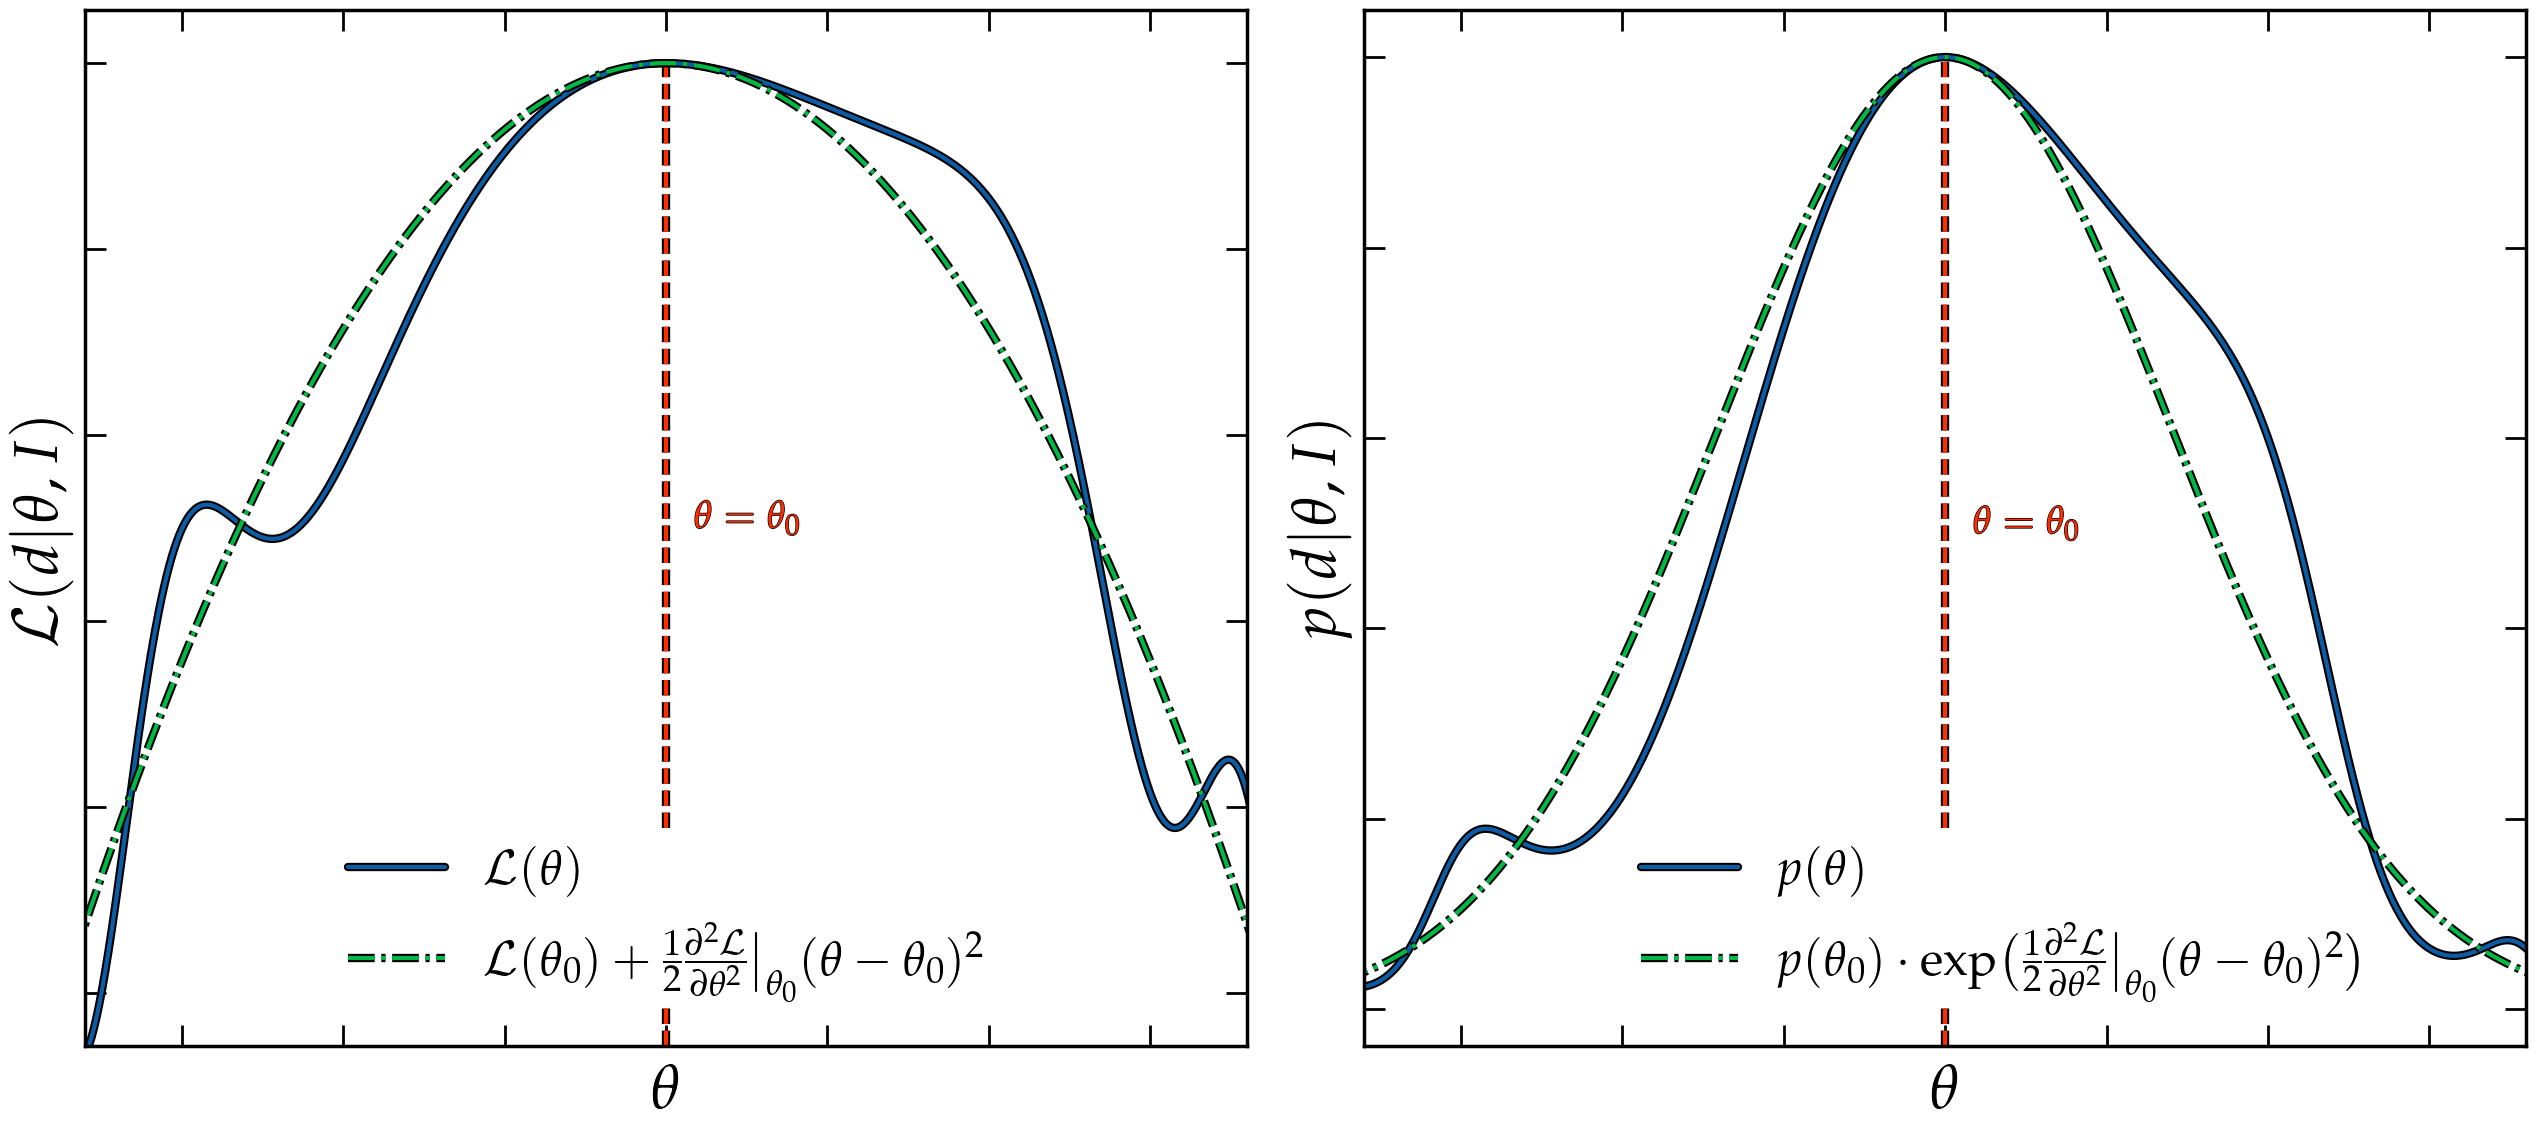

In [ ]:
theta = np.linspace(-2,2,1000)
fish_log = -theta**2
func_log = -theta**2 + 0.5*np.sin((theta/0.9)**3)

plt.figure(figsize=(26,12))

plt.subplot(1,2,1)
plt.axvline(x=0,ymin=0.21,ymax=0.95,color='C3',path_effects=path_effects,ls='--')
plt.axvline(x=0,ymin=0,ymax=0.04,color='C3',path_effects=path_effects,ls='--')
plt.plot(theta, func_log,path_effects=path_effects, label=r'$\mathcal{L}(\theta)$')
plt.plot(theta, fish_log,ls='-.',path_effects=path_effects, label=r'$\mathcal{L}(\theta_0) + \frac{1}{2} \frac{\partial^2 \mathcal{L}}{\partial \theta^2} \big|_{\theta_0} (\theta-\theta_0)^2$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\mathcal{L}(d|\theta,I)$')
plt.yticks(ticks=[-3.5,-2.8,-2.1,-1.4,-0.7,0],labels=['']*6)
plt.xticks(ticks=[-1.5,-1,-0.5,0,0.5,1,1.5],labels=['']*7)
plt.xlim(-1.8,1.8)
plt.ylim(-3.7,0.2)
plt.annotate(r'$\theta = \theta_0$',
            xy=(0.25, -1.75), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)
plt.legend()

plt.subplot(1,2,2)
plt.axvline(x=0,ymin=0.21,ymax=0.95,color='C3',path_effects=path_effects,ls='--')
plt.axvline(x=0,ymin=0,ymax=0.04,color='C3',path_effects=path_effects,ls='--')
plt.plot(theta, np.exp(func_log),path_effects=path_effects,label=r'$p(\theta)$')
plt.plot(theta, np.exp(fish_log),ls='-.',path_effects=path_effects,label=r'$p(\theta_0) \cdot \exp \! \big( \frac{1}{2} \frac{\partial^2 \mathcal{L}}{\partial \theta^2} \big|_{\theta_0} (\theta-\theta_0)^2 \big)$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(d|\theta,I)$')
plt.xticks(ticks=[-1.5,-1,-0.5,0,0.5,1,1.5],labels=['']*7)
plt.yticks(ticks=[0,0.2,0.4,0.6,0.8,1],labels=['']*6)
plt.xlim(-1.8,1.8)
plt.legend(loc='lower center',bbox_to_anchor=(0.55,0.0))
plt.annotate(r'$\theta = \theta_0$',
            xy=(0.25, 0.5), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)

plt.tight_layout()
#plt.savefig('laplace.pdf',dpi=300,bbox_inches='tight')
plt.show()

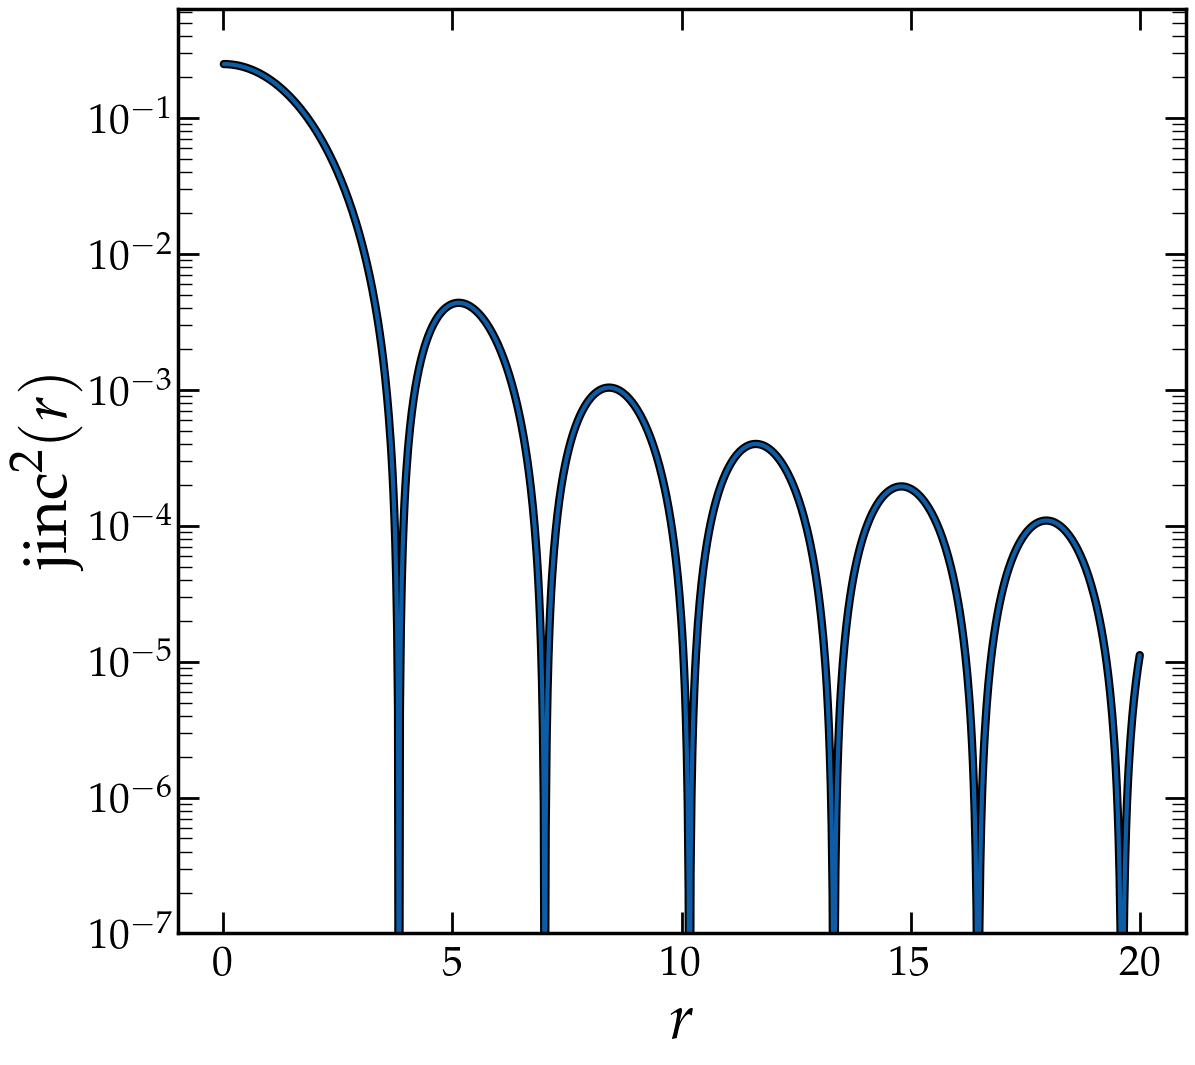

In [111]:
rs=np.linspace(0.01,20,1000)

jinc2 = j1(rs)**2/rs**2

plt.plot(rs,jinc2,path_effects=path_effects)
plt.xlabel(r'$r$')
plt.ylabel(r'$\mathrm{jinc}^2 (r)$')
plt.yscale('log')

plt.ylim(10**(-7),10**(-0.2))
plt.show()

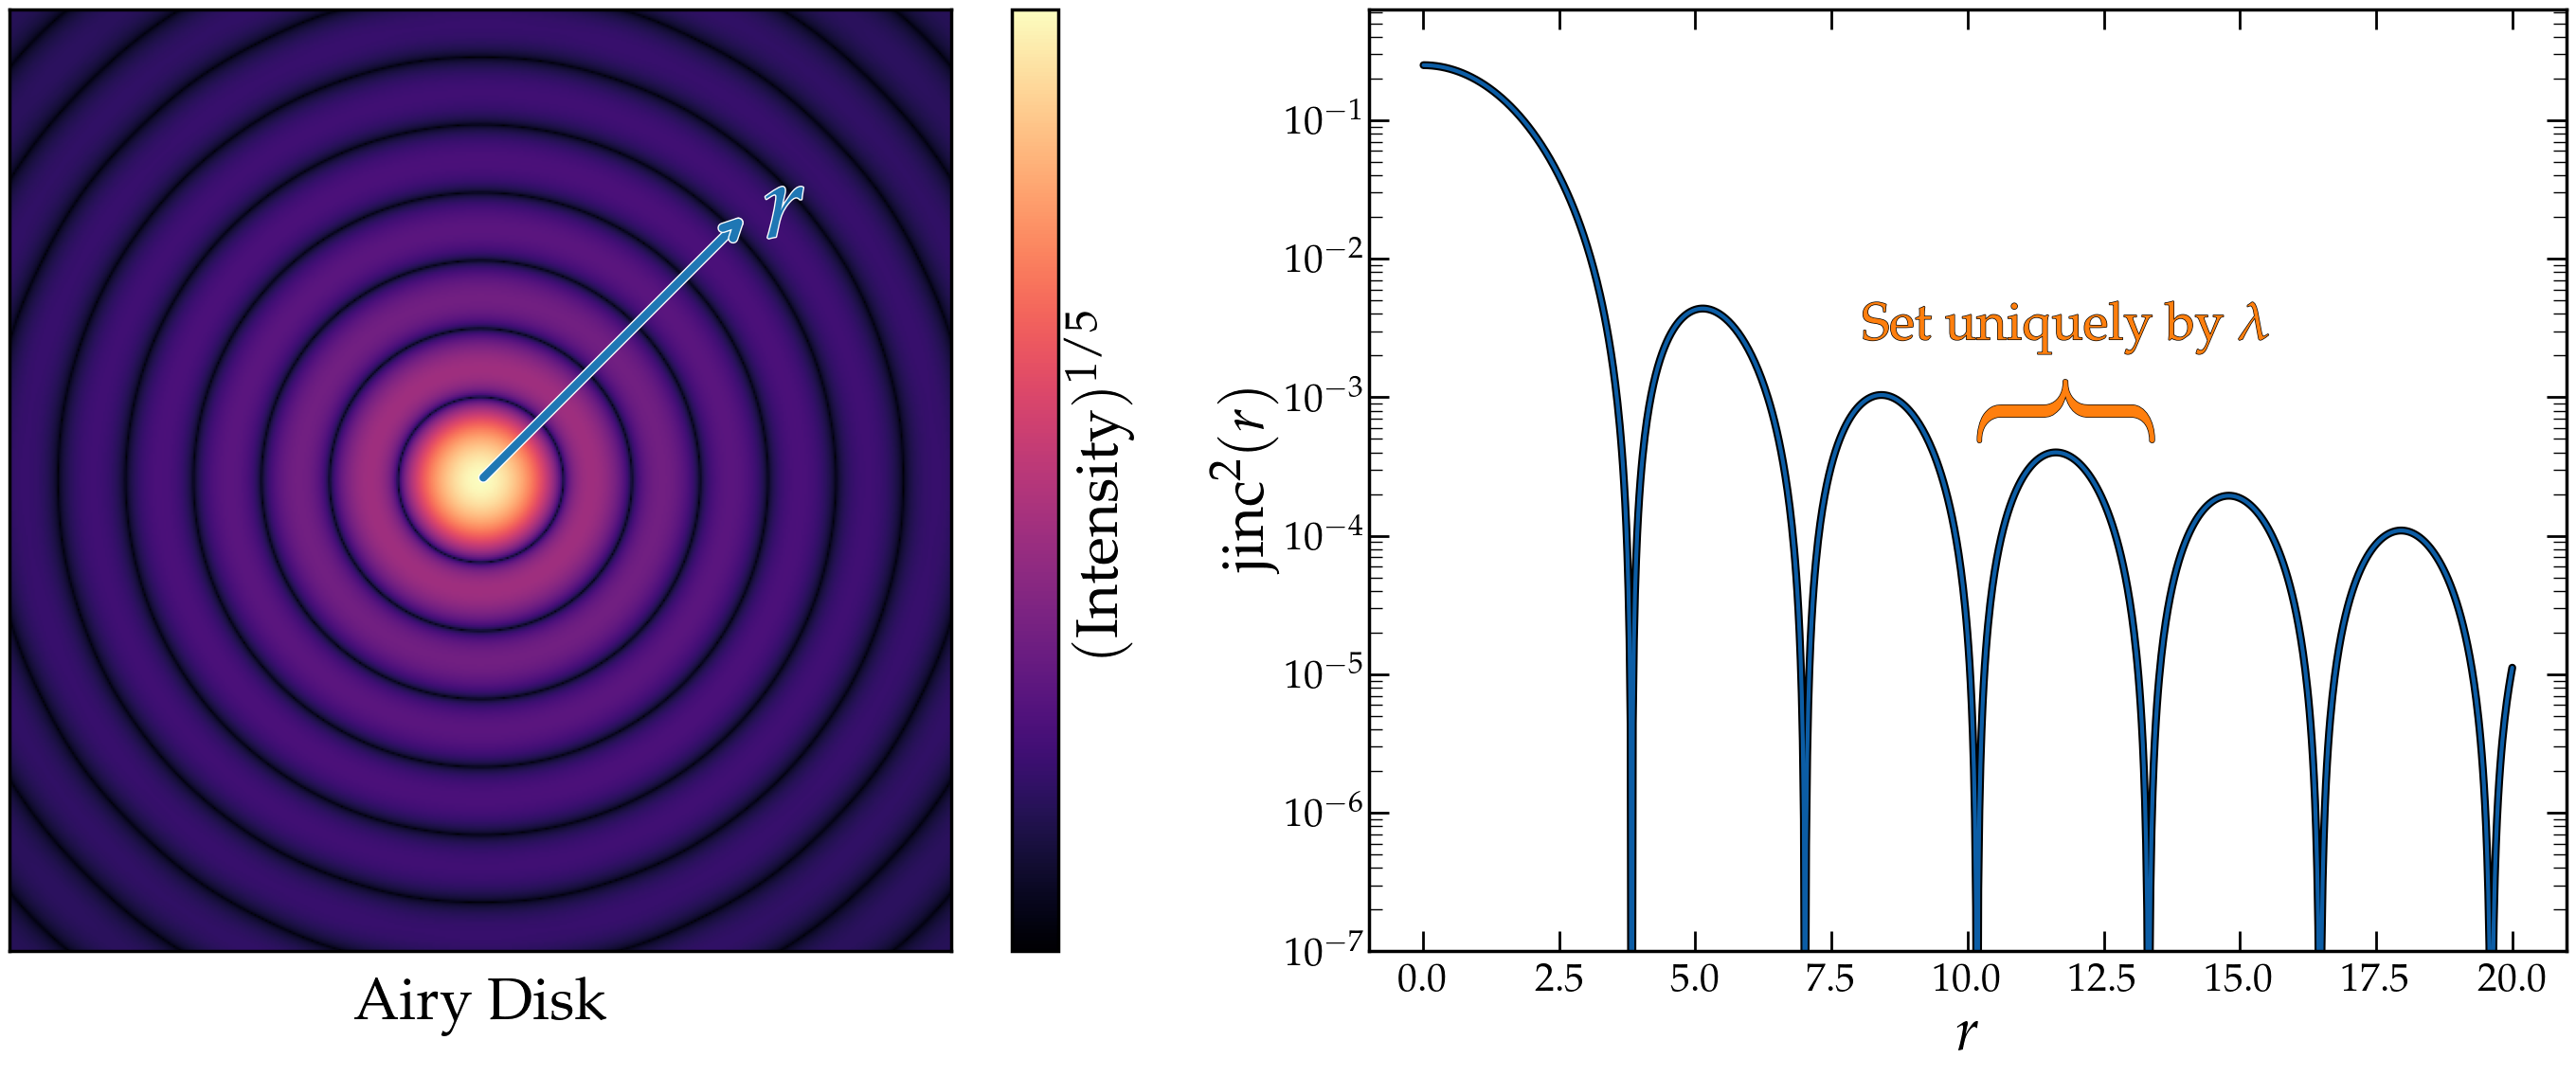

In [ ]:
# let us do a plt imshow of an airy disk
path_effects_big = [pe.Stroke(linewidth=8, foreground='white'), pe.Normal()]
path_effects_white = [pe.Stroke(linewidth=2, foreground='white'), pe.Normal()]

fig = plt.figure(figsize=(28,12))
ax = fig.add_subplot(1,2,1)
im = ax.imshow((airy_data)**0.2, origin='lower', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([])
cbar.set_label(r'$(\mathrm{Intensity})^{1/5}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Airy Disk',labelpad=20)
ax.annotate(
    "",
    xy=(256, 256),               # tail
    xytext=(400, 400),           # head
    arrowprops=dict(arrowstyle='<-', linewidth=6, color='tab:blue', ls='-',path_effects=path_effects_big)
)

ax.text(
    420, 400,
    r"$r$",
    va='center', ha='center',
    path_effects=path_effects_white, color='tab:blue', fontsize=80
)


ax2 = fig.add_subplot(1,2,2)
ax2.plot(rs,jinc2,path_effects=path_effects)
ax2.set_xlabel(r'$r$')
ax2.set_ylabel(r'$\mathrm{jinc}^2 (r)$')
ax2.set_yscale('log')

ax2.text(
    11.8, 10**(-2.5),
    r"Set uniquely by $\lambda$",
    va='center', ha='center',
    path_effects=text_path_effects, color='tab:orange', fontsize=40
)

ax2.text(
    11.7, 10**(-3.1),
    r"\{",
    va='center', ha='center',
    path_effects=text_path_effects, color='tab:orange', fontsize=135, rotation=-90
)

ax2.set_ylim(10**(-7),10**(-0.2))


plt.tight_layout()

#plt.savefig('airyjinc.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [33]:
# gonna need this for fisher infos
from jax.scipy.special import gammaln, xlogy, j1, j0
import dLux.utils as dlu
import jax.numpy as np

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

import zodiax as zdx

In [34]:
# This is the wavelength fisher info figure
wl = 1e-6
D = 1
r_max = 10*wl/D
P = np.logspace(-6,3,100)

def large_P_approx(Flob, D, wl, r_max):
    lP = (8*Flob*D*r_max)/(wl**3)
    return lP

def small_P_approx(Flob, D, P, wl):
    sP = (2*Flob*np.pi**2*D**2)/(P**2*wl**2)
    return sP

def fisher_no_approx(Flob, P, D, wl, r_max):
    nP = (Flob*2*(12*np.pi*P**2*D/wl*r_max+3*np.pi**3*D**2+(6*np.pi-16)*P**2))/(wl**2*3*np.pi*P**2)
    return nP

Flob = 1e6
sp_approx = small_P_approx(Flob, D, P, wl)
lp_approx = large_P_approx(Flob, D, wl, r_max) * np.ones_like(P)
np_fisher = fisher_no_approx(Flob, P, D, wl, r_max)

# Numerically calculating
wf_npix = 512  # Number of pixels in the wavefront

# Construct a simple circular aperture
coords = dlu.pixel_coords(wf_npix, D)
aperture = dlu.circle(coords, 0.5 * D)

# Define our detector properties
psf_npix = 512  # Number of pixels in the PSF
psf_pixel_scale = dlu.rad2arcsec(1/np.sqrt(2)*r_max/(psf_npix/2))
oversample = 4  # Oversampling factor for the PSF

# Define the optical layers
# Note here we can pass in a tuple of (key, layer) paris to be able to 
# access the layer from the optics object with the key!
layers = [
    (
        "aperture",
        dl.layers.TransmissiveLayer(transmission=aperture, normalise=True),
    )
]

# Construct the optics object
optics = dl.AngularOpticalSystem(
    wf_npix, D, layers, psf_npix, psf_pixel_scale, oversample
)
depth = 0.696*np.pi

f_factor = j0(depth/4)**2 * j1(depth/4)**2

source = dl.PointSource(np.array([wl]),flux = Flob/(4*f_factor))

telescope = dl.Telescope(optics, source)

fisher_infos = []
params = 'wavelengths'
#print(telescope)
for idx, period in enumerate(P):
    sidelobescope = dlT.SideLobeCLIMB(telescope, period, depth, wl)
    data = sidelobescope.model()
    fish_info = zdx.fisher.fisher_matrix(sidelobescope, params, poiss_loglike, data)
    fisher_infos.append(fish_info)
    print(idx)

Model time: 0.8560 seconds.
Model time: 2.4095 seconds.
0
Model time: 0.0439 seconds.
Model time: 0.3926 seconds.
1
Model time: 0.0422 seconds.
Model time: 0.4092 seconds.
2
Model time: 0.0417 seconds.
Model time: 0.3818 seconds.
3
Model time: 0.0414 seconds.
Model time: 0.3806 seconds.
4
Model time: 0.0413 seconds.
Model time: 0.3805 seconds.
5
Model time: 0.0418 seconds.
Model time: 0.3883 seconds.
6
Model time: 0.0414 seconds.
Model time: 0.3837 seconds.
7
Model time: 0.0416 seconds.
Model time: 0.3808 seconds.
8
Model time: 0.0412 seconds.
Model time: 0.3858 seconds.
9
Model time: 0.0680 seconds.
Model time: 0.5081 seconds.
10
Model time: 0.0418 seconds.
Model time: 0.4022 seconds.
11
Model time: 0.0434 seconds.
Model time: 0.3995 seconds.
12
Model time: 0.0428 seconds.
Model time: 0.3844 seconds.
13
Model time: 0.0411 seconds.
Model time: 0.3816 seconds.
14
Model time: 0.0439 seconds.
Model time: 0.3772 seconds.
15
Model time: 0.0428 seconds.
Model time: 0.3872 seconds.
16
Model t

In [35]:
fish_array = np.array(fisher_infos).squeeze()

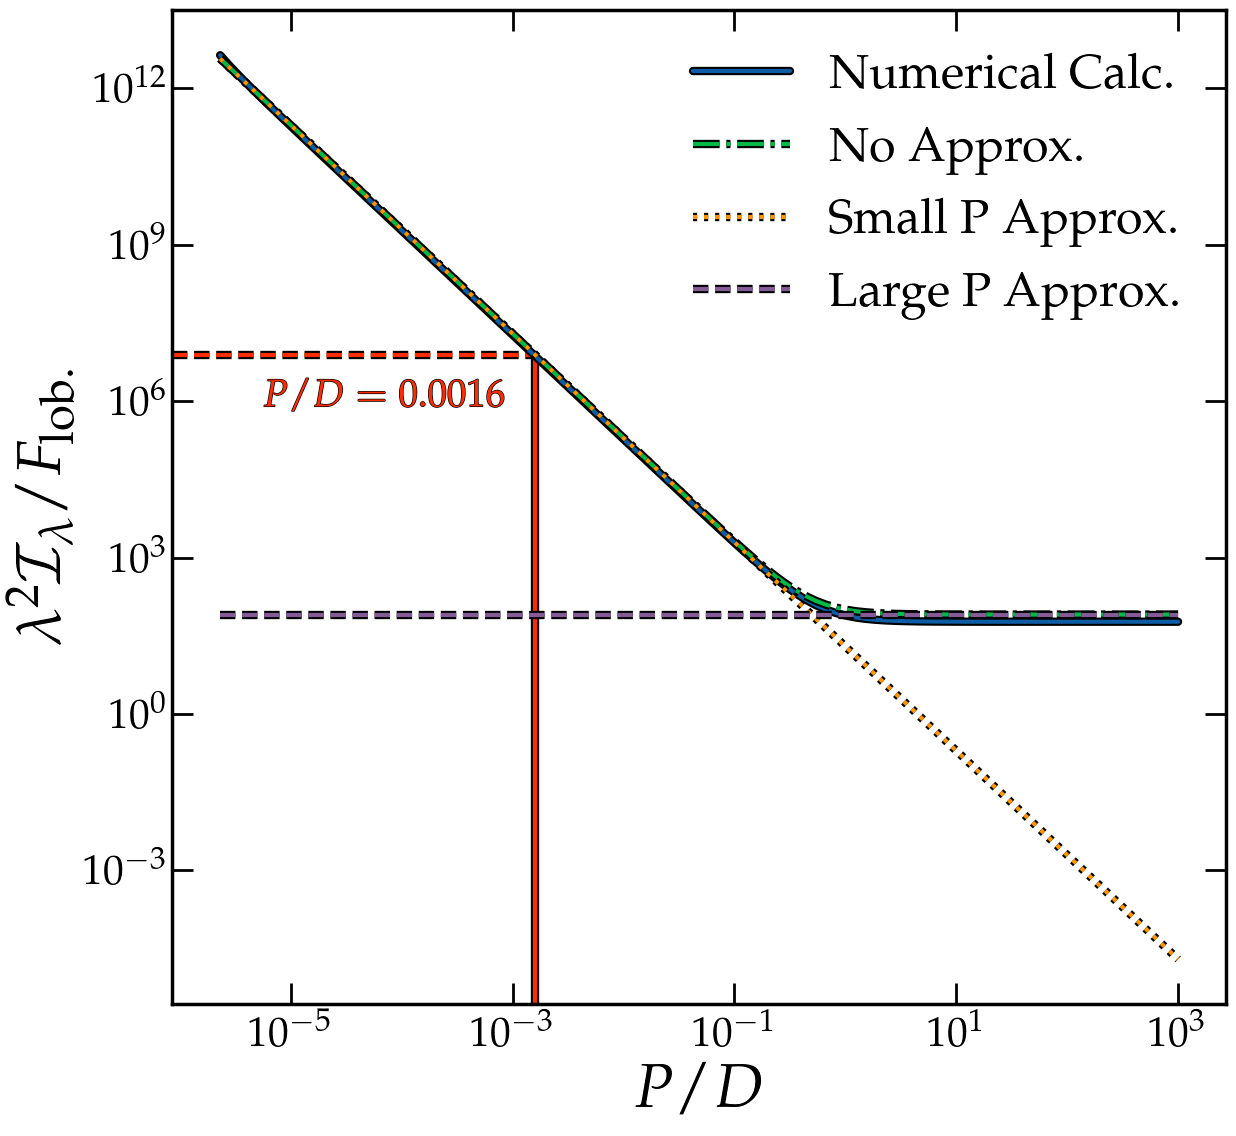

In [ ]:
# --- PLOTTING ---
plt.style.use('../wk17/sty.mplstyle')

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

plt.axvline(0.0016, color='C3', path_effects=path_effects, ymax=0.65)
plt.axhline(small_P_approx(1,1,0.0016,1), color='C3', path_effects=path_effects, xmax=0.345, ls='--')

i = 4

plt.plot(P[i:], fish_array[i:]*wl**2/Flob, path_effects=path_effects, label='Numerical Calc.', ls='-', color='C0')
plt.plot(P[i:], np_fisher[i:]*wl**2/Flob, path_effects=path_effects, label='No Approx.', ls='-.',color='C1')
plt.plot(P[i:], sp_approx[i:]*wl**2/Flob, path_effects=path_effects, label='Small P Approx.', ls=':',color='C2')
plt.plot(P[i:], lp_approx[i:]*wl**2/Flob, path_effects=path_effects, label='Large P Approx.', ls='--',color='C4')


plt.annotate(r'$P/D = 0.0016$',
            xy=(0.00007, 10**5.9), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)

plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\lambda^2 \mathcal{I}_{\lambda} / F_{\mathrm{lob.}}$')
plt.xlabel(r'$P/D$')
plt.legend()
plt.tight_layout()

#plt.savefig('smalllargeP.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [38]:
import pandas as pd
from scipy.stats import binned_statistic
def large_P_approx(Flob, D, wl, r_max):
    lP = (8*Flob*D*r_max)/(wl**3)
    return lP

def small_P_approx(Flob, D, P, wl):
    sP = (2*Flob*np.pi**2*D**2)/(P**2*wl**2)
    return sP

def fisher_no_approx(Flob, P, D, wl, r_max):
    nP = (Flob*2*(12*np.pi*P**2*D/wl*r_max+3*np.pi**3*D**2+(6*np.pi-16)*P**2))/(wl**2*3*np.pi*P**2)
    return nP

In [39]:
# Now, the most difficult/annoying figure to make:
# Pixel scale fisher information from the toliman sidelobes.
wf_npix = 196
oversample = 1
diameter = 0.125
psf_npix = 420
psf_pixel_scale = 0.375

aperture = dlT.TolimanApertureLayer(wf_npix)
layers = [
    (
        'aperture',
        aperture
    )
]
optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)

downsample_layer = dl.detector_layers.Downsample(oversample)

detector_layers = [
    (
        'downsample',
        downsample_layer
    )
]
detector = dl.LayeredDetector(detector_layers)

# flux rates per second
alphaCenAFlux = 2.909e8
alphaCenBFlux = 9.023e7
totalFlux = alphaCenAFlux + alphaCenBFlux

# import the wavelengths:
# Step 1: Load from CSV
df_A = pd.read_csv("../wk12/alpha_cen_A_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask_A = (df_A["wavelength"] >= 5200) & (df_A["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths_A = df_A["wavelength"][mask_A].to_numpy() * 1e-10  # meters
weights_A = df_A["flux"][mask_A].to_numpy()

# Step 4: Downsample using binning
n_bins = 600
bin_means_A, bin_edges_A, _ = binned_statistic(
    wavelengths_A, weights_A, statistic='mean', bins=n_bins
)
bin_centers_A = 0.5 * (bin_edges_A[:-1] + bin_edges_A[1:])

# now for alpha cen B
df_B = pd.read_csv("../wk12/alpha_cen_B_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask_B = (df_A["wavelength"] >= 5200) & (df_A["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths_B = df_B["wavelength"][mask_B].to_numpy() * 1e-10  # meters
weights_B = df_B["flux"][mask_B].to_numpy()

bin_means_B, bin_edges_B, _ = binned_statistic(
    wavelengths_B, weights_B, statistic='mean', bins=n_bins
)

bin_centers_B = 0.5 * (bin_edges_B[:-1] + bin_edges_B[1:])

# specify exposure times
exposure_times = np.logspace(-4,6,3)
# 20 should be more than enough points?

# period, depth of the grating
period = 200e-6
depth = 0.696*np.pi

lobeFac = j1(depth/4)**2 * j0(depth/4)**2

center_wl = 585e-9

In [40]:
print(optics)

AngularOpticalSystem(
  wf_npixels=196,
  diameter=0.125,
  layers={
    'aperture': TolimanApertureLayer(transmission=f32[196,196], normalise=True)
  },
  psf_npixels=420,
  oversample=1,
  psf_pixel_scale=0.375
)


In [46]:
params = 'psf_pixel_scale'
covs = []
#exposure_times = np.array([1])
for idx, e_time in enumerate(exposure_times):
    source_A = dl.PointSource(bin_centers_A, dlu.arcsec2rad(np.array([-4,0])), e_time*alphaCenAFlux, bin_means_A)
    source_B = dl.PointSource(bin_centers_B, dlu.arcsec2rad(np.array([4,0])), e_time*alphaCenBFlux, bin_means_B)

    sources = dl.Scene([source_A, source_B])

    telescope = dl.Telescope(optics, sources, detector)

    sidelobescope = dlT.SideLobeCLIMB(telescope, period, depth, center_wl, psf_pixel_scale)

    data = sidelobescope.model()

    print('hi')
    cov = zdx.covariance_matrix(sidelobescope, params, poiss_loglike, data)

    covs.append(cov)
    print(idx)

Model time: 24.4348 seconds.
hi
Model time: 68.7366 seconds.
0
Model time: 21.7962 seconds.
hi
Model time: 67.8185 seconds.
1
Model time: 22.5539 seconds.
hi
Model time: 69.9098 seconds.
2


In [47]:
sidelobe_safe = data

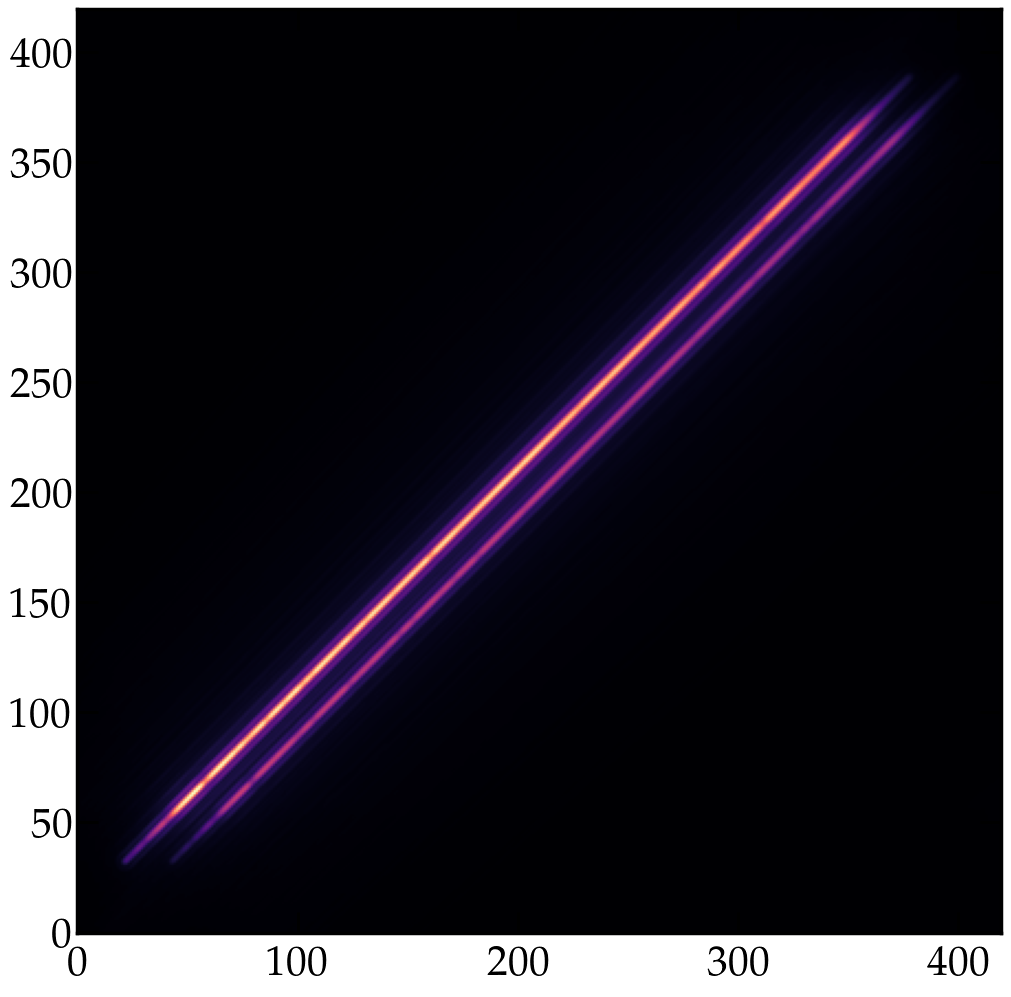

In [48]:
plt.imshow(data**0.5, origin='lower', cmap='magma')

In [49]:
covs_array = np.array(covs).squeeze()

In [50]:
params = 'psf_pixel_scale'
covs_total = []
#exposure_times = np.array([1])
for idx, e_time in enumerate(exposure_times):
    source_total = dl.PointSource(np.array([585e-9]), dlu.arcsec2rad(np.array([0,0])), e_time*totalFlux)

    telescope = dl.Telescope(optics, source_total, detector)

    sidelobescope = dlT.SideLobeCLIMB(telescope, period, depth, center_wl, psf_pixel_scale)

    data = sidelobescope.model()

    print('hi')
    cov = zdx.covariance_matrix(sidelobescope, params, poiss_loglike, data)

    covs_total.append(cov)
    print(idx)

Model time: 0.0713 seconds.
hi
Model time: 0.0614 seconds.
0
Model time: 0.0208 seconds.
hi
Model time: 0.0469 seconds.
1
Model time: 0.0190 seconds.
hi
Model time: 0.0488 seconds.
2


In [51]:
covs_total_array = np.array(covs_total).squeeze()

In [52]:
import jax.numpy as np
import matplotlib.pyplot as plt
plt.style.use('../wk17/sty.mplstyle')

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

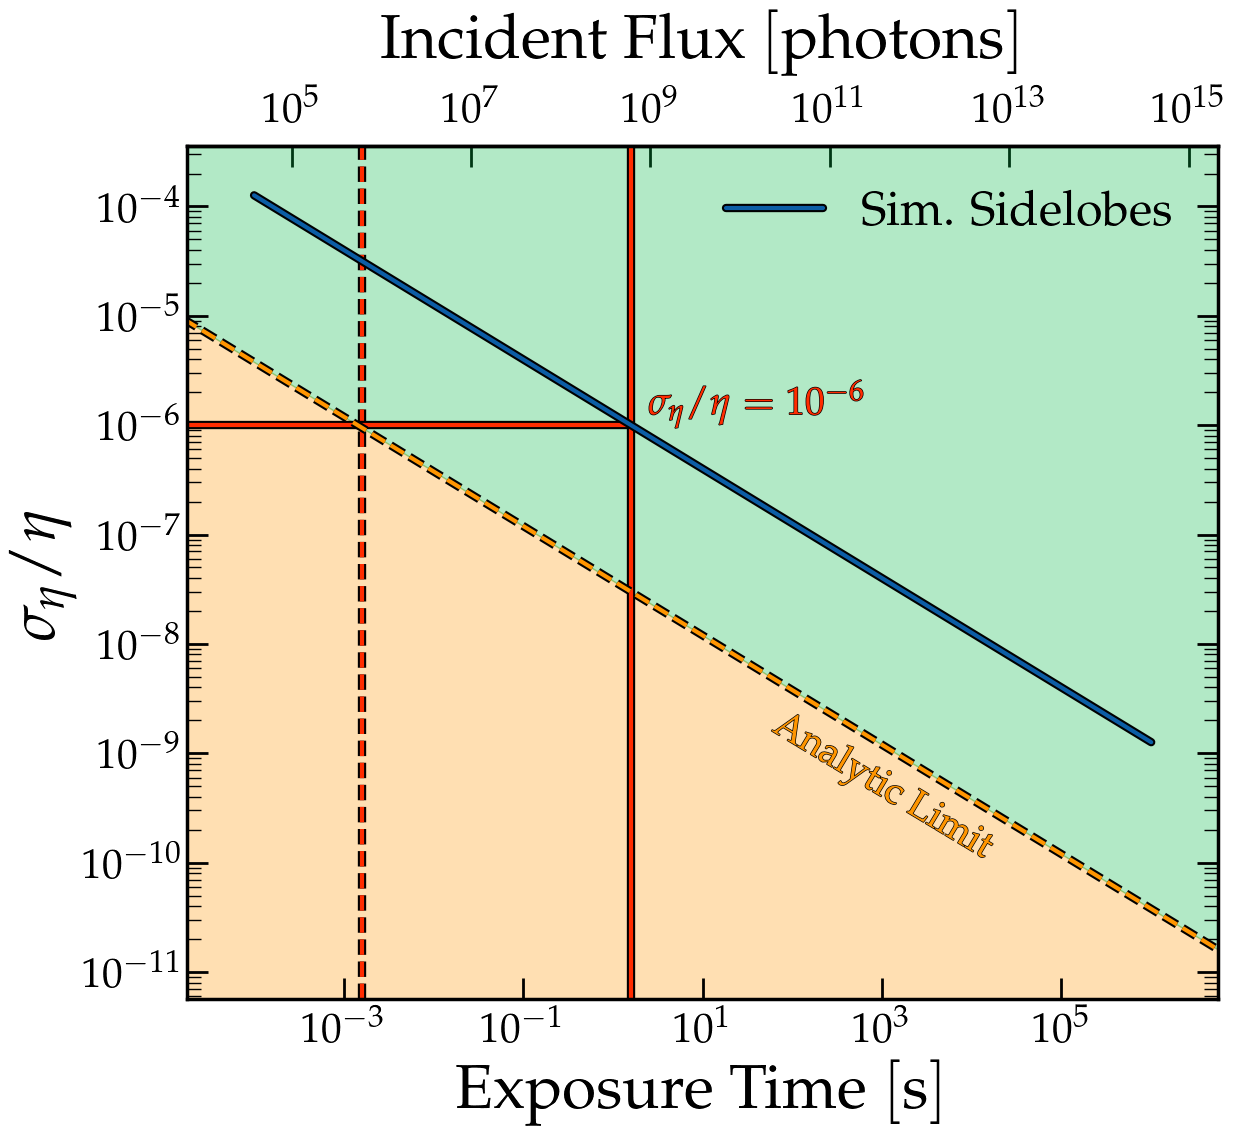

In [53]:


more_exp_times = np.logspace(-5,7,3)
flux_total_lobe = 4*more_exp_times*totalFlux*lobeFac

analytic_pscale_stdev = np.sqrt((period**2)/(2*flux_total_lobe*np.pi**2*diameter**2))
#analytic_bounds = 1/np.sqrt(small_P_approx(flux_total_lobe, diameter, period, center_wl))/dlu.arcsec2rad(psf_pixel_scale)

plt.axvline(10**(0.2), ymax=1, path_effects=path_effects, color='C3')
plt.axvline(10**(-2.8), ymax=1, path_effects=path_effects, color='C3', ls='--')
plt.axhline(1e-6, xmax=0.427, path_effects=path_effects, color='C3')


plt.plot(exposure_times, np.sqrt(covs_array)/psf_pixel_scale, path_effects=path_effects, label='Sim. Sidelobes')
plt.plot(more_exp_times, analytic_pscale_stdev, color='C2', ls='--', path_effects=path_effects)
#plt.plot(exposure_times, np.sqrt(covs_total_array)/psf_pixel_scale)

plt.fill_between(more_exp_times, analytic_pscale_stdev, alpha=0.3, color='C2')
plt.fill_between(more_exp_times, analytic_pscale_stdev, 10**(-3),alpha=0.3, color='C1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Exposure Time $[\mathrm{s}]$')
plt.ylabel(r'$\sigma_\eta/\eta$')
plt.xlim(10**(-4.75),10**(6.75))
plt.ylim(10**(-11.25),10**(-3.45))
#plt.xticks(minor=True)
plt.legend()

def photons(exptime):
    ph = exptime*totalFlux
    return ph

def exptime(photons):
    et = photons/totalFlux
    return et

plt.tick_params(
    axis='x',
    which='both',
    top=False,
)

ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(photons,exptime))
secax.set_xlabel(r'Incident Flux $[\mathrm{photons}]$',labelpad=25)

plt.annotate(r'$\sigma_\eta/\eta = 10^{-6}$',
            xy=(10**(1.6), 10**(-5.9)), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)


plt.annotate(r'Analytic Limit',
            xy=(10**(3), 10**(-9.95)), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C2',
            ha='center',
            rotation=-31,
            path_effects=text_path_effects)

plt.tight_layout()

#plt.savefig('pscaleflux.png',dpi=300,bbox_inches='tight')
plt.show()


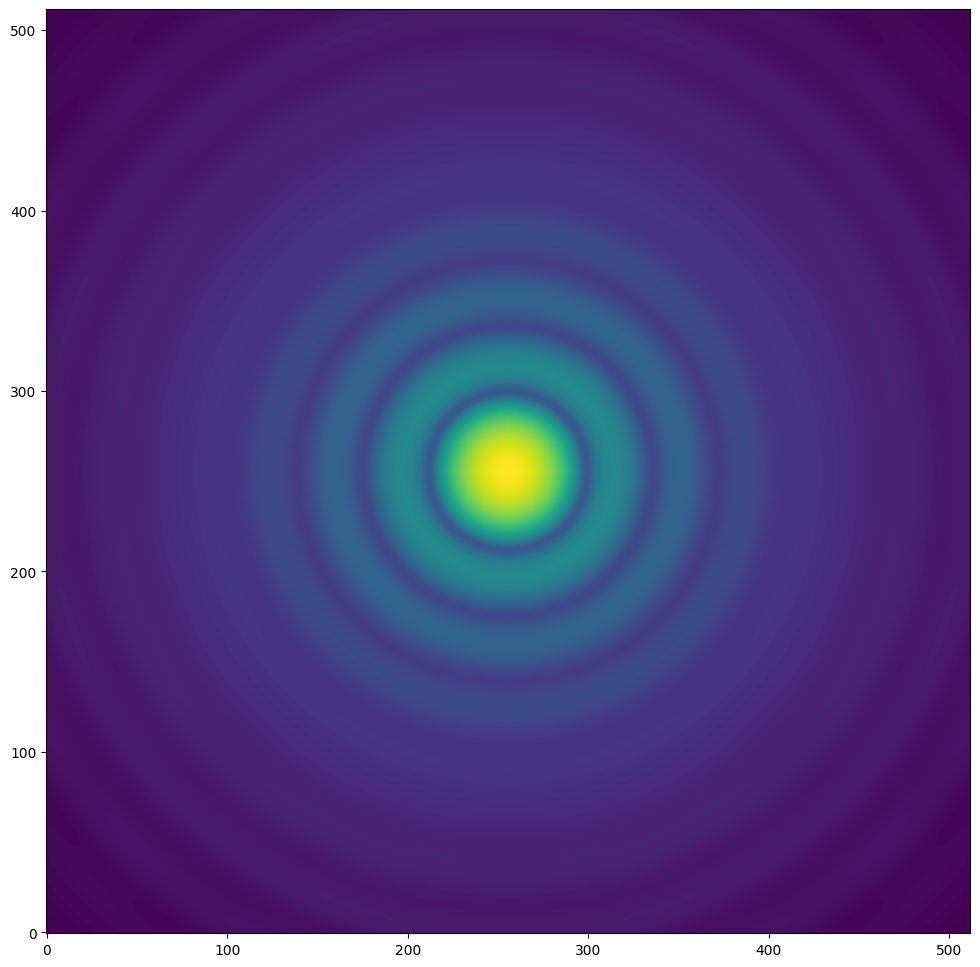

In [15]:
# This is the wavelength fisher info figure
wl = 585e-9
D = 0.125
r_max = 10*wl/D
P = np.logspace(-6,3,100)

# Numerically calculating
wf_npix = 128  # Number of pixels in the wavefront

# Construct a simple circular aperture
coords = dlu.pixel_coords(wf_npix, D)
aperture = dlu.circle(coords, 0.5 * D)

# Define our detector properties
psf_npix = 128  # Number of pixels in the PSF
psf_pixel_scale = dlu.rad2arcsec(1/np.sqrt(2)*r_max/(psf_npix/2))
oversample = 4  # Oversampling factor for the PSF

# Define the optical layers
# Note here we can pass in a tuple of (key, layer) paris to be able to 
# access the layer from the optics object with the key!
layers = [
    (
        "aperture",
        dl.layers.TransmissiveLayer(transmission=aperture, normalise=True),
    )
]

# Construct the optics object
optics_airy = dl.AngularOpticalSystem(
    wf_npix, D, layers, psf_npix, psf_pixel_scale, oversample
)

source_airy = dl.PointSource(bin_centers_A, dlu.arcsec2rad(np.array([0,0])), 1e9, bin_means_A)

telescope_airy = dl.Telescope(optics_airy, source_airy)

airy_data = telescope_airy.model()

plt.figure(figsize=(13,12))
plt.imshow(airy_data**0.1,origin='lower', cmap='viridis')
plt.show()

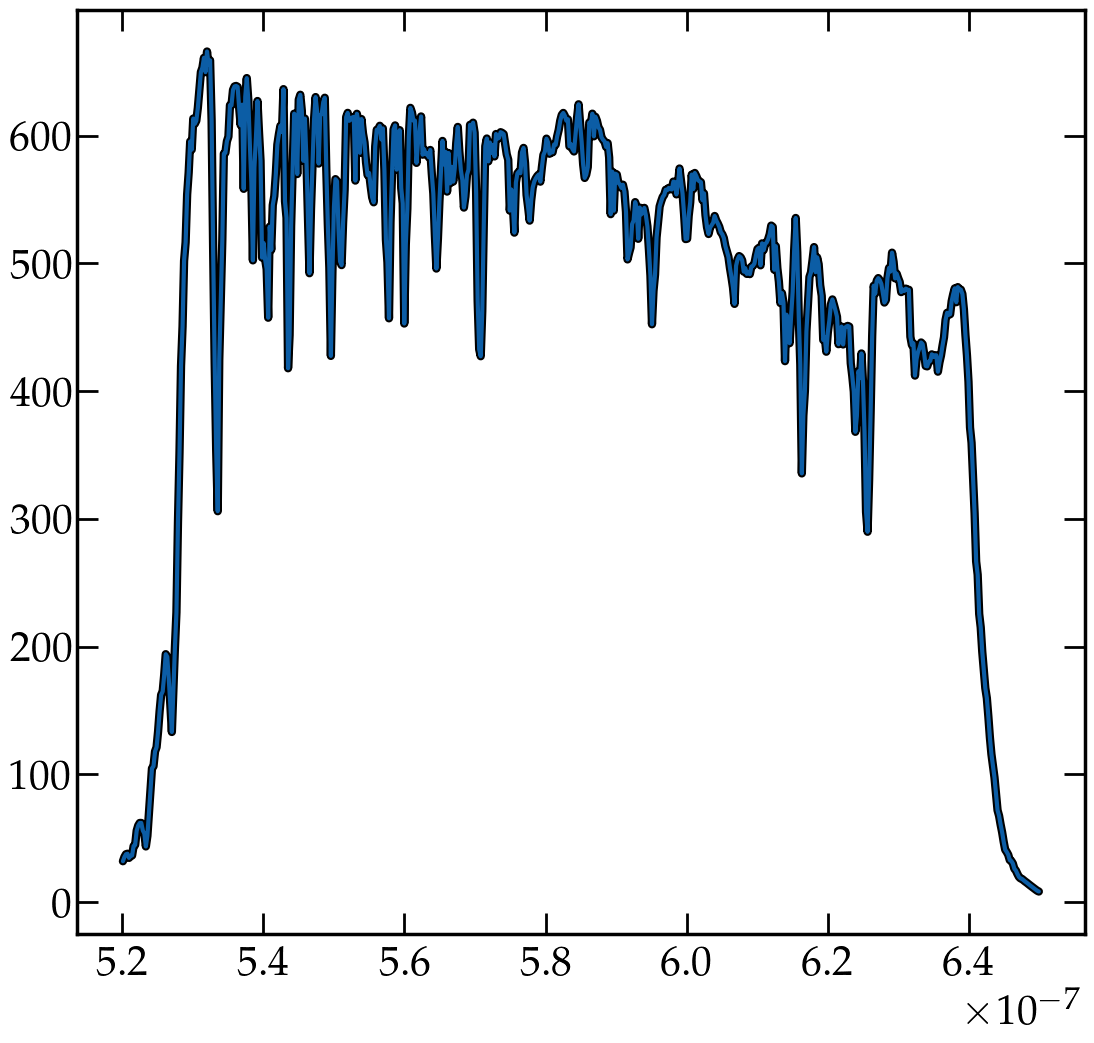

In [20]:
plt.plot(bin_centers_A, bin_means_A, path_effects=path_effects)
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:26: SyntaxWarning: invalid escape sequence '\h'
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_25297/395091646.py:26: SyntaxWarning: invalid escape sequence '\h'
  """


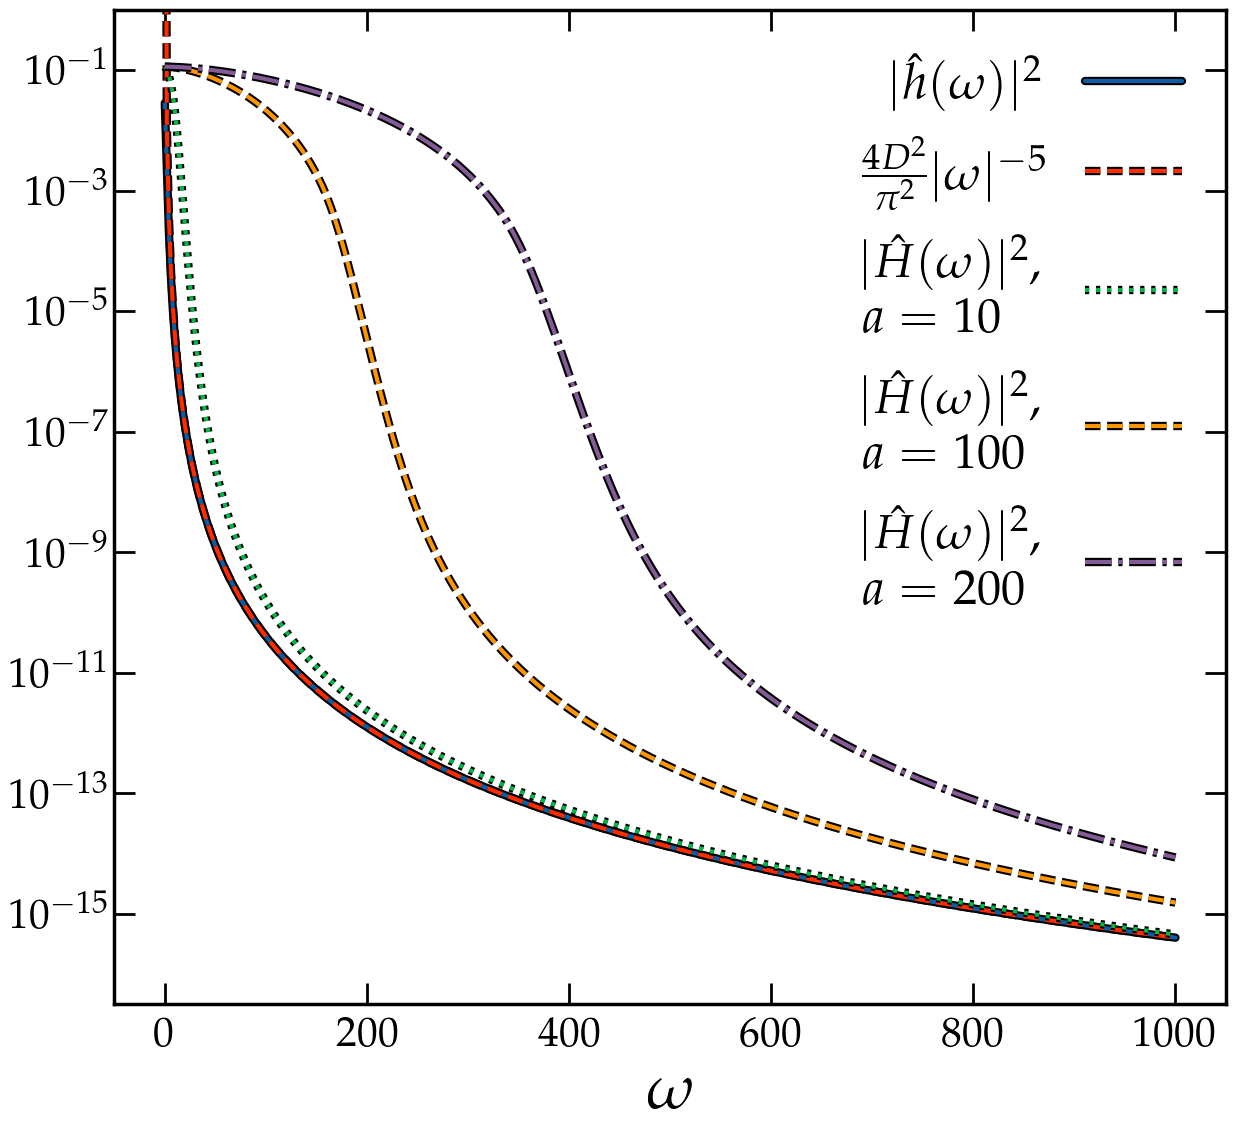

In [ ]:
# sidelobe
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

# --- precision -------------------------------------------------------------
mp.mp.dps = 30  # increase if you push to very large |omega|

# --- parameters ------------------------------------------------------------
D = 1.0         # diameter-like scale (set to your value)
a = 100         # defocus / aperture param in your _2F3 terms (set to your value)
W = 1000.0       # plot up to |omega| <= W
N = 500         # number of samples

# --- definitions -----------------------------------------------------------
def F_simple(omega, D=D):
    """F(ω) = (π^{-iω} D^{1-iω}) / (2√(2π)) * Γ(1 - iω/2)Γ(1/2 + iω/2) / [Γ(1/2)Γ(3/2 - iω/2)Γ(5/2 - iω/2)]"""
    w = mp.mpf(omega)
    iy2 = mp.mpc(0, w/2)
    pref = mp.power(mp.pi, -1j*w) * mp.power(D, 1 - 1j*w) / (2*mp.sqrt(2*mp.pi))
    num = mp.gamma(1 - iy2) * mp.gamma(mp.mpf('0.5') + iy2)
    den = mp.gamma(mp.mpf('0.5')) * mp.gamma(mp.mpf('1.5') - iy2) * mp.gamma(mp.mpf('2.5') - iy2)
    return pref * (num/den)

def h_hat(omega, D=D, a=a):
    """
    \hat{h}(ω) with the two {}_2F_3 terms as provided.
    """
    w = mp.mpf(omega)
    iy2 = mp.mpc(0, w/2)
    pref = mp.power(mp.pi, -1j*w) * mp.power(D, 1 - 1j*w) / (2*mp.sqrt(2*mp.pi))

    # --- Term 1 ---
    num1 = mp.gamma(mp.mpf('1.5') - iy2) * mp.gamma(1 + iy2)
    den1 = mp.gamma(mp.mpf('1.5')) * mp.gamma(2 - iy2) * mp.gamma(3 - iy2)
    hyp1 = mp.hyper([mp.mpf('0.5') - iy2, mp.mpf('1.5') - iy2],
                    [mp.mpf('1.5'), 2 - iy2, 3 - iy2],
                    -a*a)
    term1 = a * (num1/den1) * hyp1

    # --- Term 2 ---
    num2 = mp.gamma(1 - iy2) * mp.gamma(mp.mpf('0.5') + iy2)
    den2 = mp.gamma(mp.mpf('0.5')) * mp.gamma(mp.mpf('1.5') - iy2) * mp.gamma(mp.mpf('2.5') - iy2)
    hyp2 = mp.hyper([1 - iy2, -iy2],
                    [mp.mpf('0.5'), mp.mpf('1.5') - iy2, mp.mpf('2.5') - iy2],
                    -a*a)
    term2 = (num2/den2) * hyp2

    return pref * (term1 + term2)

# --- sample grid -----------------------------------------------------------
omegas = np.linspace(0.01, W, N)

# --- evaluate magnitudes ---------------------------------------------------
mag_simple = np.array([abs(complex(F_simple(float(w)))) for w in omegas])

mags_hhat = []
aes = np.array([10, 100, 200])
for a in aes:
    mag_hhat   = np.array([abs(complex(h_hat(float(w), a=a)))    for w in omegas])
    mags_hhat.append(mag_hhat)

mags_hhat_array = np.array(mags_hhat)

# --- plot (both on one figure) --------------------------------------------
# plt.figure(figsize=(13,12))
# plt.plot(omegas, mag_simple, label=r'$|F(\omega)|$ (gamma-ratio)')
# plt.plot(omegas, mag_hhat,   label=r'$|\hat h(\omega)|$ (with ${}_2F_3$ terms)', linestyle='--')
# plt.yscale('log')
# plt.xlabel(r'$\omega$')
# plt.ylabel('magnitude')
# plt.title('Magnitudes of $F(\\omega)$ and $\\hat h(\\omega)$')
# plt.legend()
# plt.grid(True, which='both', alpha=0.3)
# plt.tight_layout()
# plt.show()

# --- OPTIONAL: overlay asymptotic envelope (uncomment to see) -------------
C = 2*D/np.pi
asym_envelope = C * np.power(np.maximum(1e-12, np.abs(omegas)), -2.5)
plt.figure(figsize=(13,12))
plt.plot(omegas, mag_simple**2, label=r'$|\hat h(\omega)|^2$',path_effects=path_effects)

plt.plot(omegas, asym_envelope**2, label=r'$\frac{4D^2}{\pi^2} |\omega|^{-5}$', linestyle='--',path_effects=path_effects,color='C3')

plt.plot(omegas, mags_hhat_array[0]**2,   label=r'$|\hat H(\omega)|^2$,' + '\n' + r'$a=10$', linestyle=':',path_effects=path_effects)
plt.plot(omegas, mags_hhat_array[1]**2,   label=r'$|\hat H(\omega)|^2$,' + '\n' + r'$a=100$', linestyle='--',path_effects=path_effects)
plt.plot(omegas, mags_hhat_array[2]**2,   label=r'$|\hat H(\omega)|^2$,' + '\n' + r'$a=200$', linestyle='-.',path_effects=path_effects, color='C4')

plt.yscale('log')
plt.xlabel(r'$\omega$')
# plt.ylabel('magnitude')
# plt.title('Magnitudes with asymptotic envelope')
plt.ylim(10**(-16.5),10**(0))
plt.legend(markerfirst=False)
#plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
#plt.savefig('kernels.pdf',dpi=300,bbox_inches='tight')
plt.show()


NameError: name 'supergauss' is not defined

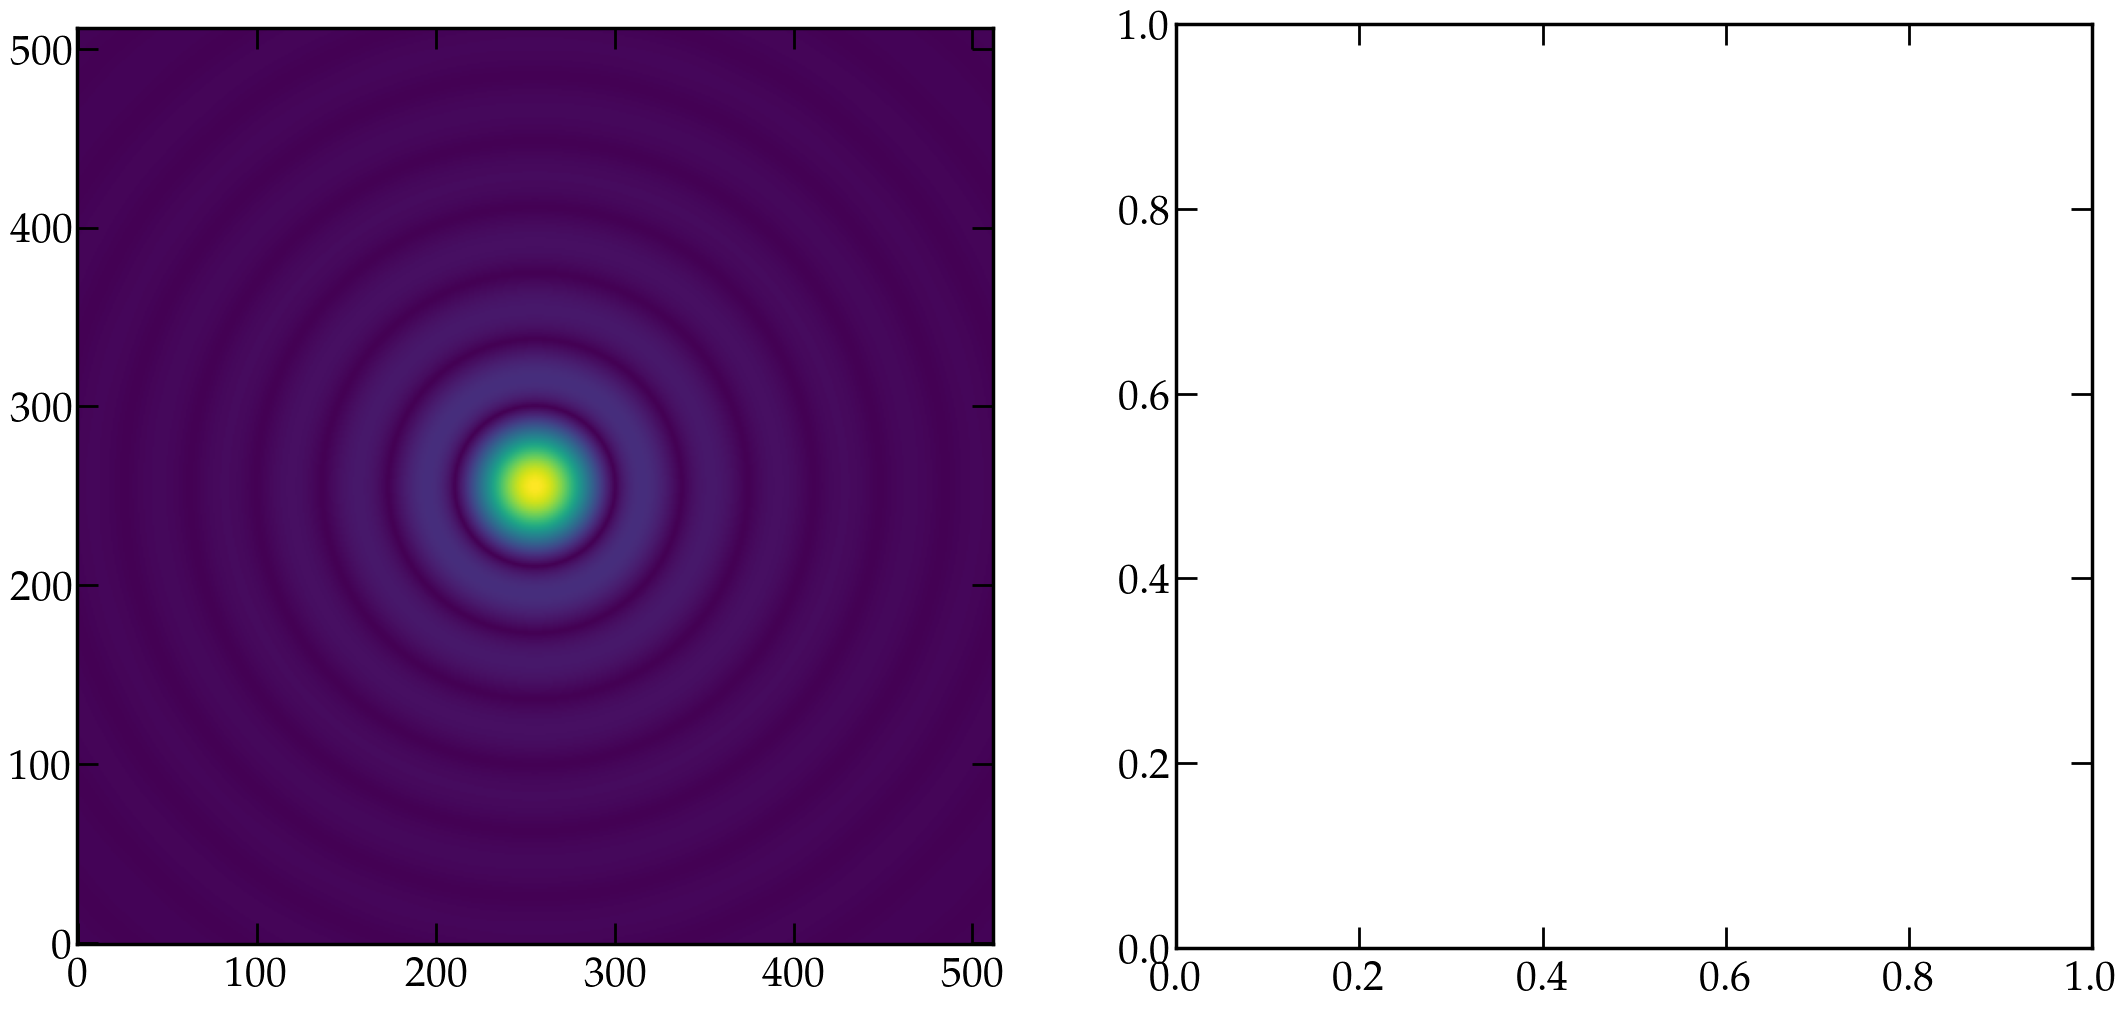

In [91]:
# diffuser image
# This is the wavelength fisher info figure
wl = 585e-9
D = 0.125
d2 = 0.0125*5
r_max = 10*wl/D
P = np.logspace(-6,3,100)

# Numerically calculating
wf_npix = 128  # Number of pixels in the wavefront

# Construct a simple circular aperture
coords = dlu.pixel_coords(wf_npix, D)
aperture = dlu.circle(coords, 0.5 * D)

# Define our detector properties
psf_npix = 128  # Number of pixels in the PSF
psf_pixel_scale = dlu.rad2arcsec(1/np.sqrt(2)*r_max/(psf_npix/2))
oversample = 4  # Oversampling factor for the PSF

# Define the optical layers
# Note here we can pass in a tuple of (key, layer) paris to be able to 
# access the layer from the optics object with the key!
layers = [
    (
        "aperture",
        dl.layers.TransmissiveLayer(transmission=aperture, normalise=True),
    )
]

# Construct the optics object
optics_airy = dl.AngularOpticalSystem(
    wf_npix, D, layers, psf_npix, psf_pixel_scale, oversample
)

optics_diffuse = dl.AngularOpticalSystem(
    wf_npix, d2, layers, psf_npix, psf_pixel_scale, oversample
)

source_airy = dl.PointSource(np.array([595e-9]), dlu.arcsec2rad(np.array([0,0])), 1e9)

telescope_airy = dl.Telescope(optics_airy, source_airy)

telescope_diffuse = dl.Telescope(optics_diffuse, source_airy)

airy_data = telescope_airy.model()
diffuse_data = telescope_diffuse.model()

plt.figure(figsize=(26,12))
plt.subplot(1,2,1)
plt.imshow(airy_data**0.5,origin='lower', cmap='viridis')

plt.subplot(1,2,2)
plt.imshow(supergauss**0.5, origin='lower', cmap='viridis')

plt.tight_layout()
plt.show()

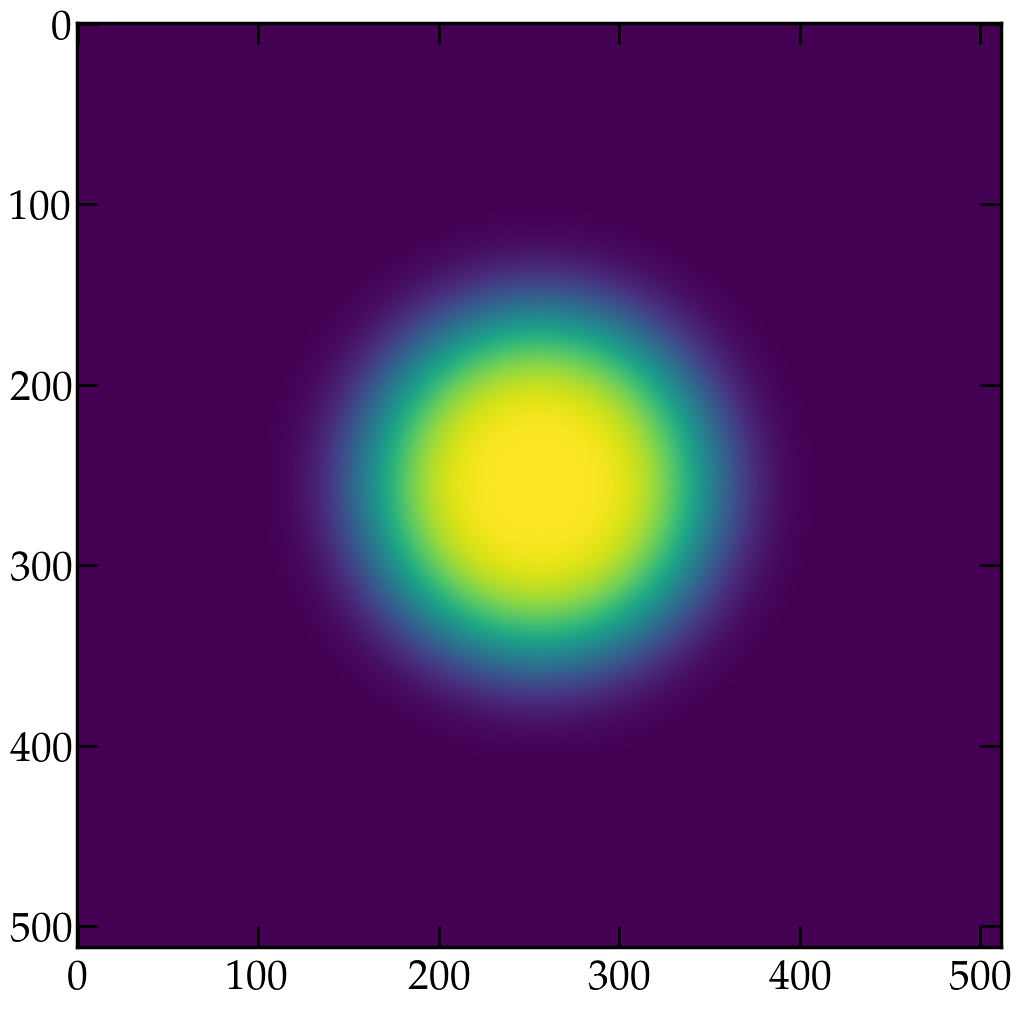

In [51]:
# Parameters
N = 512
sigma = 100.0    # standard-width-like parameter (in pixels)
order = 4.0     # super-gaussian order (2 => gaussian, 4+ => super-gaussian)
amplitude = 1.0

# Coordinate grid centered in the middle of the array
x = np.arange(N)
y = np.arange(N)
xx, yy = np.meshgrid(x, y, indexing='xy')
cx = (N - 1) / 2.0
cy = (N - 1) / 2.0

# Radial distance from center
r = np.sqrt((xx - cx)**2 + (yy - cy)**2)

# Super-Gaussian
supergauss = amplitude * np.exp(- (r / sigma)**order)

plt.imshow(supergauss)

In [139]:
# importing the optimised grating
phase = np.load("bestoptgrating.npy")

coords = dl.utils.pixel_coords(256, 0.125)

a = 500
grate = np.sin((coords[0]+coords[1])*a) + np.sin((coords[0] - coords[1])*a)

grate *=  dlT.TolimanApertureLayer(256).transmission * (phase/np.max(phase)*2 - 1)/2

grate *= 1.7180986820985287/2
print(np.min(grate))

# grating depth of: 1.7180986820985287
grating_layer = dl.AberratedLayer(phase = grate)

layers_new = [
    (
        'aperture',
        dlT.TolimanApertureLayer(256)
    ),
    # (
    #     'pupil',
    #     dlT.TolimanPupilLayer(512)
    # ),
    (
        'grating',
        grating_layer
    )
]

optics_new = dl.AngularOpticalSystem(256, 0.125, layers_new, 300, 0.375, 8)
source_new = dl.PointSource(np.array([585e-9]))
telescope_new = dl.Telescope(optics_new, source_new)

-0.8590266


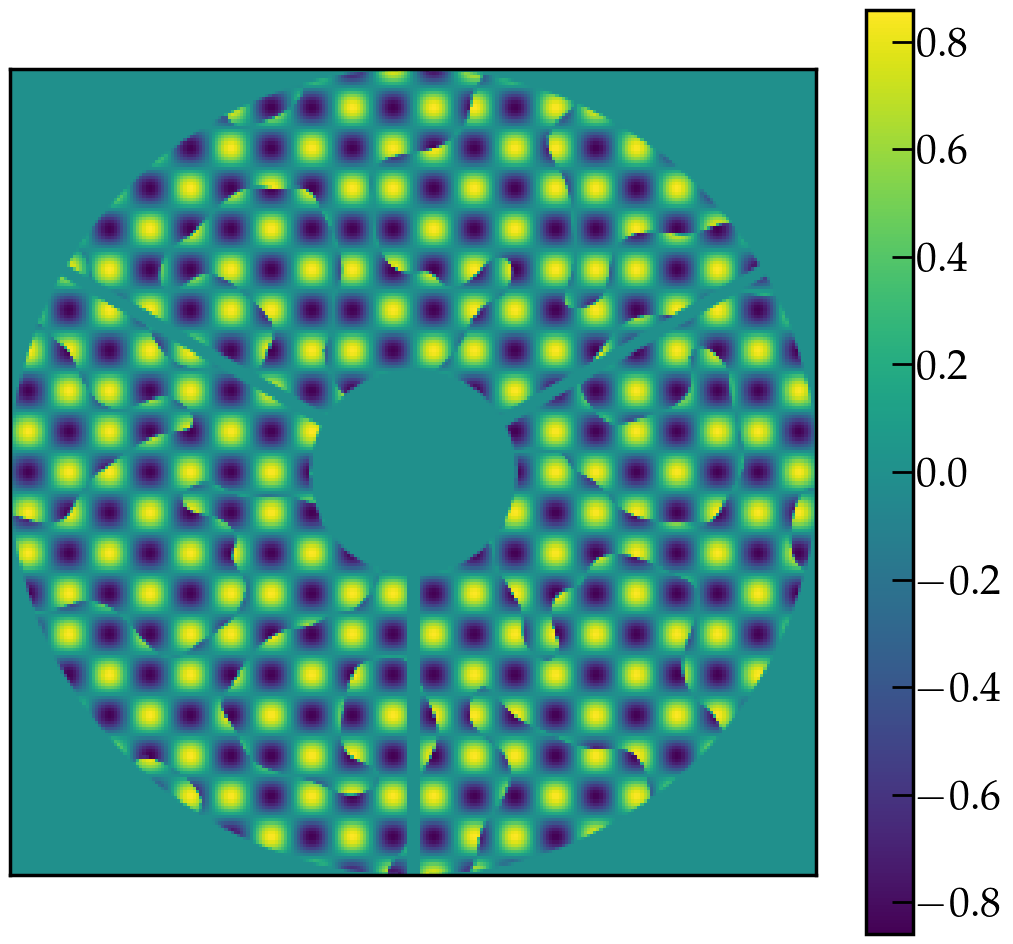

In [141]:
plt.imshow(grate, origin='lower')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

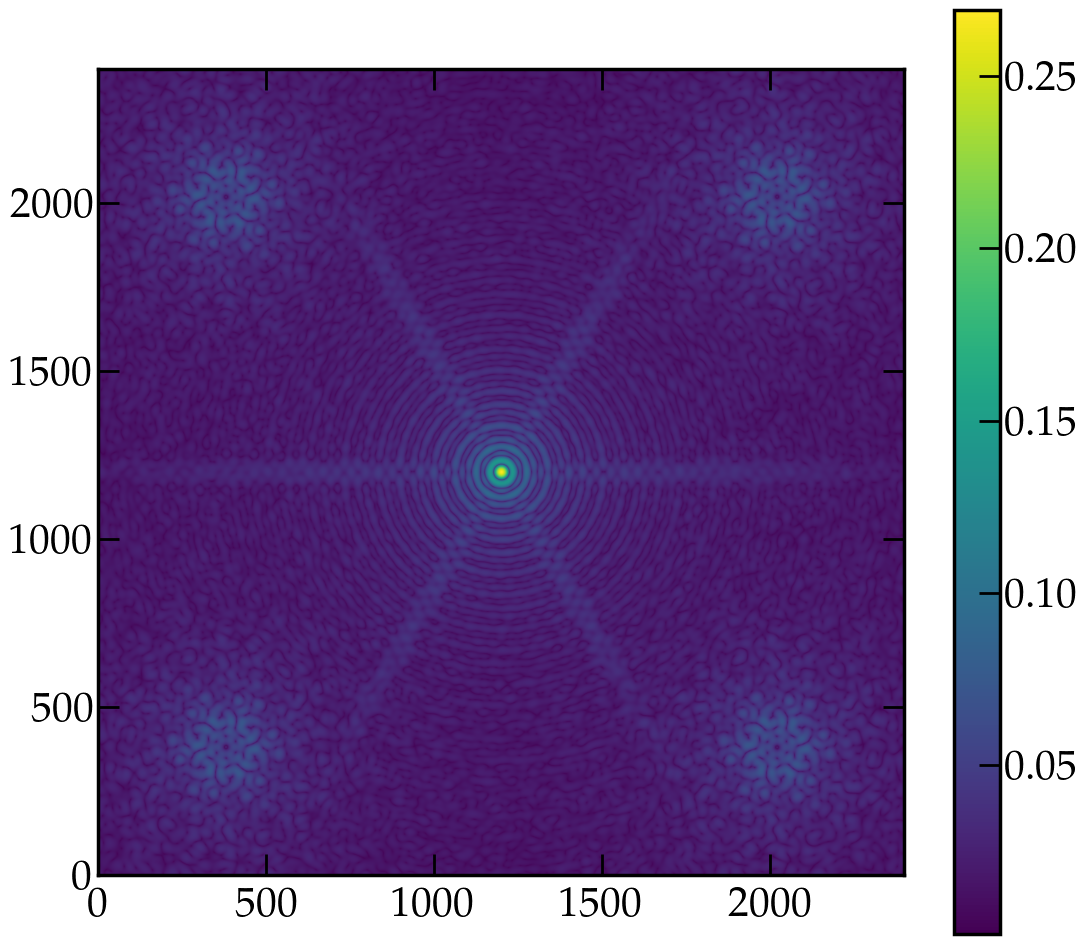

In [136]:
plt.imshow((telescope_new.model())**0.2, origin='lower')
plt.colorbar()

In [158]:
# dispersed flux:
dflux = np.load("04sne.npy")
pupil = dl.AberratedLayer(phase=dflux)

layers_new = [
    (
        'aperture',
        dlT.TolimanApertureLayer(256)
    ),
    # (
    #     'pupil',
    #     pupil
    # ),
    # (
    #     'grating',
    #     grating_layer
    # )
]

optics_new = dl.AngularOpticalSystem(256, 0.125, layers_new, 150, 0.375, 8)
source_new = dl.PointSource(np.array([585e-9]))
telescope_new = dl.Telescope(optics_new, source_new)

0.0016914675


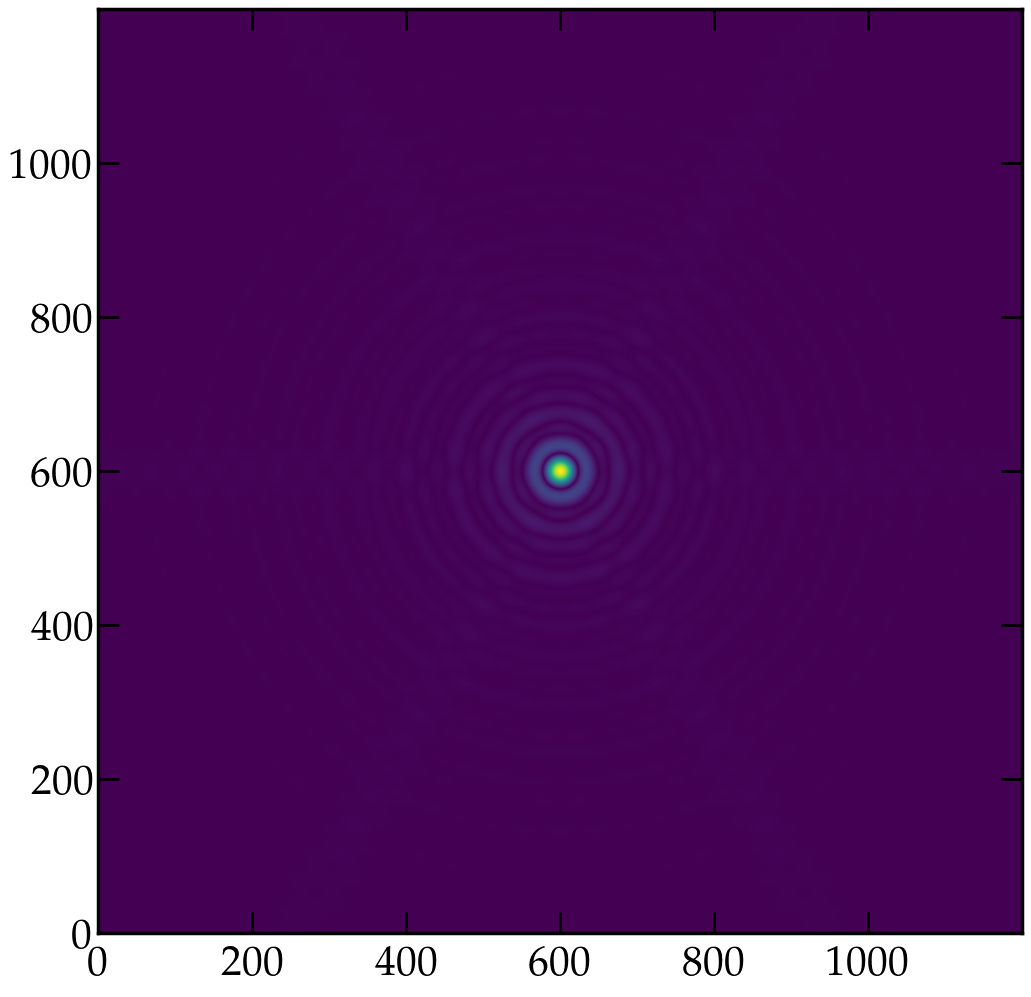

In [ ]:
plt.imshow(telescope_new.model()**0.5, origin='lower')
print(np.max(telescope_new.model()))

# 3.7670256e-05
# 0.0016914675

([], [])

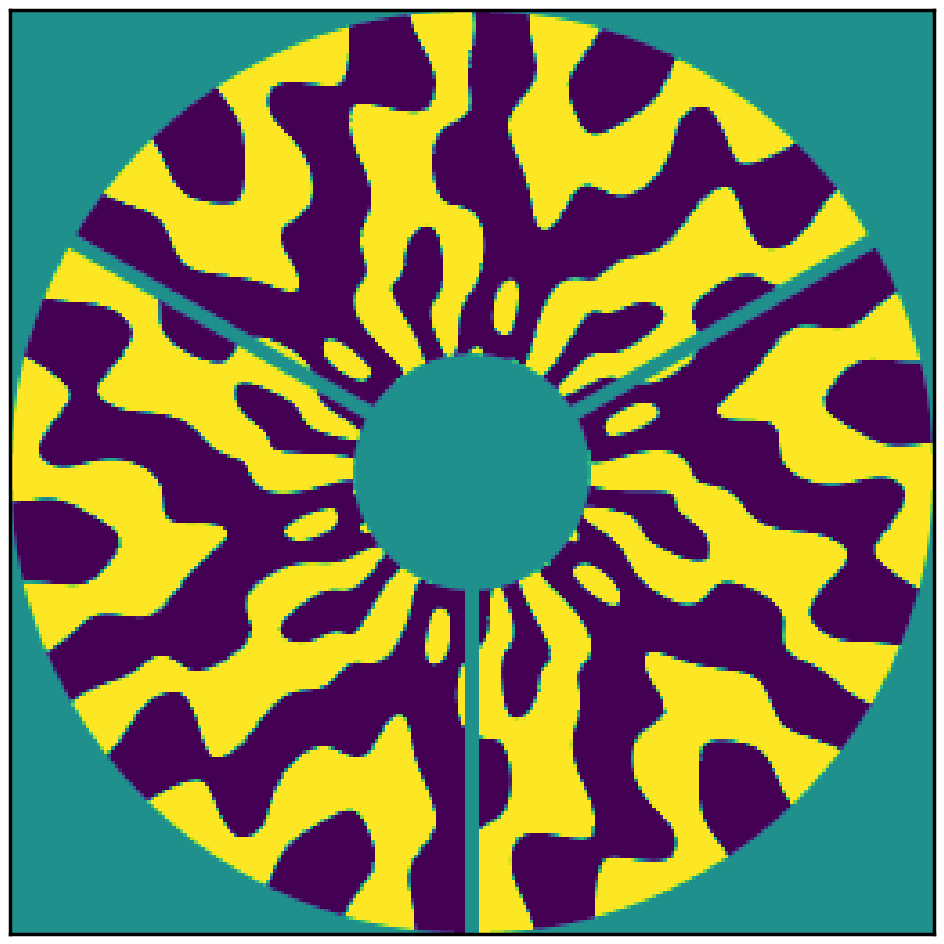

In [152]:
plt.imshow((dflux/np.pi*2-1)*dlT.TolimanApertureLayer(256).transmission, origin='lower')
plt.xticks([])
plt.yticks([])

In [161]:
print(3.7670256*10**(-5)/0.0016914675)

0.022270753650306615


([], [])

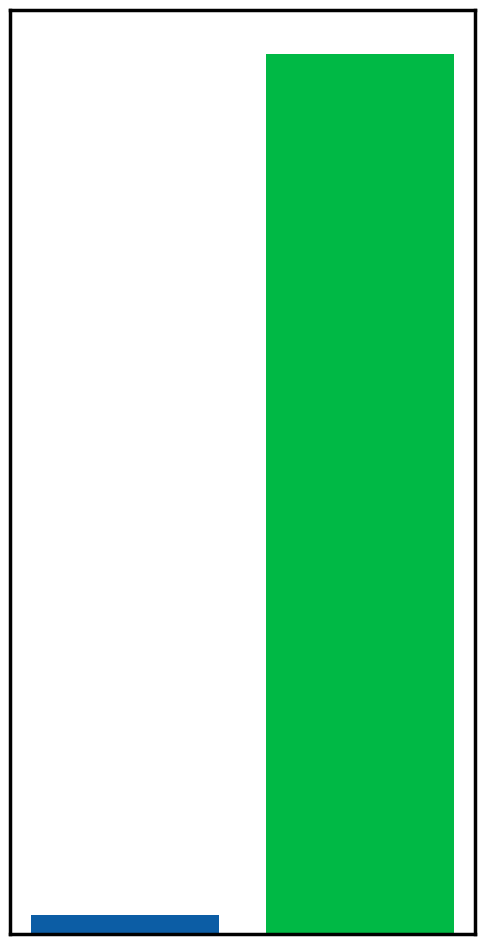

In [169]:
plt.figure(figsize=(6,12))
plt.bar(x=np.array([0,1]),height=np.array([0.022,1]), color=['C0','C1'])
plt.xticks([])
plt.yticks([])

In [54]:
# let us redo the annoying figure
import dLuxToliman as dlT
import dLux as dl
import jax.numpy as np
import pandas as pd
from scipy.stats import binned_statistic
from jax.scipy.special import j1, j0
import matplotlib.pyplot as plt
import dLux.utils as dlu
import zodiax as zdx

# Now, the most difficult/annoying figure to make:
# Pixel scale fisher information from the toliman sidelobes.
wf_npix = 196
oversample = 1
diameter = 0.125

# this one is so zoomed such that the effects of bandlimit are basically null
# so the only thing which gives us information is the absorption lines..
psf_npix_nobl = 320

# this one gets a lot of information from the bandlimit
psf_npix = 420

psf_pixel_scale = 0.375

aperture = dlT.TolimanApertureLayer(wf_npix)
layers = [
    (
        'aperture',
        aperture
    )
]

optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)

optics_nobl = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix_nobl, psf_pixel_scale, oversample)

downsample_layer = dl.detector_layers.Downsample(oversample)

detector_layers = [
    (
        'downsample',
        downsample_layer
    )
]
detector = dl.LayeredDetector(detector_layers)

# flux rates per second
alphaCenAFlux = 2.909e8
alphaCenBFlux = 9.023e7
totalFlux = alphaCenAFlux + alphaCenBFlux

# import the wavelengths:
# Step 1: Load from CSV
df_A = pd.read_csv("../wk12/alpha_cen_A_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask_A = (df_A["wavelength"] >= 5200) & (df_A["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths_A = df_A["wavelength"][mask_A].to_numpy() * 1e-10  # meters
weights_A = df_A["flux"][mask_A].to_numpy()

# Step 4: Downsample using binning
n_bins = 600
bin_means_A, bin_edges_A, _ = binned_statistic(
    wavelengths_A, weights_A, statistic='mean', bins=n_bins
)
bin_centers_A = 0.5 * (bin_edges_A[:-1] + bin_edges_A[1:])

# now for alpha cen B
df_B = pd.read_csv("../wk12/alpha_cen_B_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask_B = (df_A["wavelength"] >= 5200) & (df_A["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths_B = df_B["wavelength"][mask_B].to_numpy() * 1e-10  # meters
weights_B = df_B["flux"][mask_B].to_numpy()

bin_means_B, bin_edges_B, _ = binned_statistic(
    wavelengths_B, weights_B, statistic='mean', bins=n_bins
)

bin_centers_B = 0.5 * (bin_edges_B[:-1] + bin_edges_B[1:])

# specify exposure times
exposure_times = np.logspace(-4,6,3)
# 20 should be more than enough points?

# period, depth of the grating
period = 200e-6
depth = 0.696*np.pi

lobeFac = j1(depth/4)**2 * j0(depth/4)**2

center_wl = 585e-9

In [55]:
# gonna need this for fisher infos
from jax.scipy.special import gammaln, xlogy, j1, j0
import dLux.utils as dlu
import jax.numpy as np

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

import zodiax as zdx

In [56]:
params = 'psf_pixel_scale'
covs = []
#exposure_times = np.array([1])
for idx, e_time in enumerate(exposure_times):
    source_A = dl.PointSource(bin_centers_A, dlu.arcsec2rad(np.array([-4,0])), e_time*alphaCenAFlux, bin_means_A)
    source_B = dl.PointSource(bin_centers_B, dlu.arcsec2rad(np.array([4,0])), e_time*alphaCenBFlux, bin_means_B)

    sources = dl.Scene([source_A, source_B])

    telescope = dl.Telescope(optics, sources, detector)

    sidelobescope = dlT.SideLobeCLIMB(telescope, period, depth, center_wl, psf_pixel_scale)

    data = sidelobescope.model()

    print('hi')
    cov = zdx.covariance_matrix(sidelobescope, params, poiss_loglike, data)

    covs.append(cov)
    print(idx)

Model time: 22.3571 seconds.
hi
Model time: 67.6707 seconds.
0
Model time: 21.5000 seconds.
hi
Model time: 66.9091 seconds.
1
Model time: 21.5021 seconds.
hi
Model time: 73.1264 seconds.
2


In [57]:
covs_array = np.array(covs).squeeze()

In [58]:
# the one without the bandlimit effects

params = 'psf_pixel_scale'
covs_nobl = []
#exposure_times = np.array([1])
for idx, e_time in enumerate(exposure_times):
    source_A = dl.PointSource(bin_centers_A, dlu.arcsec2rad(np.array([-4,0])), e_time*alphaCenAFlux, bin_means_A)
    source_B = dl.PointSource(bin_centers_B, dlu.arcsec2rad(np.array([4,0])), e_time*alphaCenBFlux, bin_means_B)

    sources = dl.Scene([source_A, source_B])

    telescope = dl.Telescope(optics_nobl, sources, detector)

    sidelobescope = dlT.SideLobeCLIMB(telescope, period, depth, center_wl, psf_pixel_scale)

    data = sidelobescope.model()

    print('hi')
    cov = zdx.covariance_matrix(sidelobescope, params, poiss_loglike, data)

    covs_nobl.append(cov)
    print(idx)


Model time: 22.2444 seconds.
hi
Model time: 55.8780 seconds.
0
Model time: 21.6946 seconds.
hi
Model time: 53.9685 seconds.
1
Model time: 21.9157 seconds.
hi
Model time: 53.5987 seconds.
2


In [59]:
covs_nobl_array = np.array(covs_nobl).squeeze()

In [60]:
params = 'psf_pixel_scale'
covs_total = []
#exposure_times = np.array([1])
for idx, e_time in enumerate(exposure_times):
    source_total = dl.PointSource(np.array([585e-9]), dlu.arcsec2rad(np.array([0,0])), e_time*totalFlux)

    telescope = dl.Telescope(optics, source_total, detector)

    sidelobescope = dlT.SideLobeCLIMB(telescope, period, depth, center_wl, psf_pixel_scale)

    data = sidelobescope.model()

    print('hi')
    cov = zdx.covariance_matrix(sidelobescope, params, poiss_loglike, data)

    covs_total.append(cov)
    print(idx)

Model time: 0.1187 seconds.
hi
Model time: 0.1082 seconds.
0
Model time: 0.0190 seconds.
hi
Model time: 0.0536 seconds.
1
Model time: 0.0194 seconds.
hi
Model time: 0.0465 seconds.
2


In [61]:
covs_total_array = np.array(covs_total).squeeze()

In [62]:
import jax.numpy as np
import matplotlib.pyplot as plt
plt.style.use('../wk17/sty.mplstyle')

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

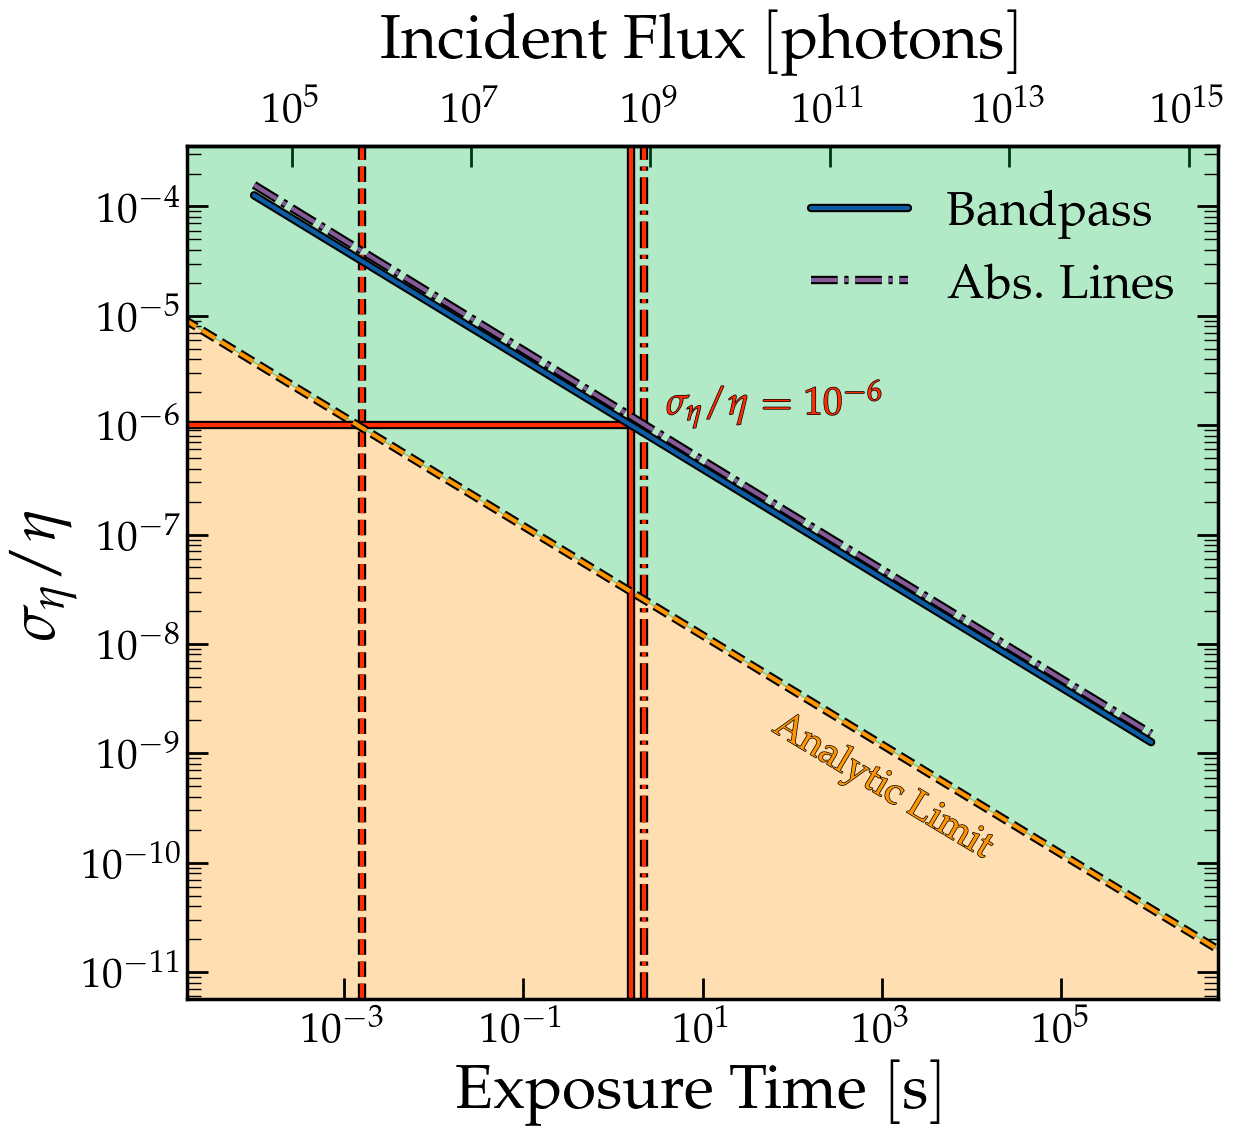

In [63]:


more_exp_times = np.logspace(-5,7,3)
flux_total_lobe = 4*more_exp_times*totalFlux*lobeFac

analytic_pscale_stdev = np.sqrt((period**2)/(2*flux_total_lobe*np.pi**2*diameter**2))
#analytic_bounds = 1/np.sqrt(small_P_approx(flux_total_lobe, diameter, period, center_wl))/dlu.arcsec2rad(psf_pixel_scale)

plt.axvline(10**(0.2), ymax=1, path_effects=path_effects, color='C3')
plt.axvline(10**(0.35), ymax=1, path_effects=path_effects, color='C3', ls='-.')

plt.axvline(10**(-2.8), ymax=1, path_effects=path_effects, color='C3', ls='--')
plt.axhline(1e-6, xmax=0.427, path_effects=path_effects, color='C3')


plt.plot(exposure_times, np.sqrt(covs_array)/psf_pixel_scale, path_effects=path_effects, label='Bandpass')
plt.plot(exposure_times, np.sqrt(covs_nobl_array)/psf_pixel_scale, path_effects=path_effects, label='Abs. Lines', ls='-.', color='C4')
plt.plot(more_exp_times, analytic_pscale_stdev, color='C2', ls='--', path_effects=path_effects)
#plt.plot(exposure_times, np.sqrt(covs_total_array)/psf_pixel_scale)

plt.fill_between(more_exp_times, analytic_pscale_stdev, alpha=0.3, color='C2')
plt.fill_between(more_exp_times, analytic_pscale_stdev, 10**(-3),alpha=0.3, color='C1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Exposure Time $[\mathrm{s}]$')
plt.ylabel(r'$\sigma_\eta/\eta$')
plt.xlim(10**(-4.75),10**(6.75))
plt.ylim(10**(-11.25),10**(-3.45))
#plt.xticks(minor=True)
plt.legend()

def photons(exptime):
    ph = exptime*totalFlux
    return ph

def exptime(photons):
    et = photons/totalFlux
    return et

plt.tick_params(
    axis='x',
    which='both',
    top=False,
)

ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(photons,exptime))
secax.set_xlabel(r'Incident Flux $[\mathrm{photons}]$',labelpad=25)

plt.annotate(r'$\sigma_\eta/\eta = 10^{-6}$',
            xy=(10**(1.8), 10**(-5.9)), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)


plt.annotate(r'Analytic Limit',
            xy=(10**(3), 10**(-9.95)), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C2',
            ha='center',
            rotation=-31,
            path_effects=text_path_effects)

plt.tight_layout()

#plt.savefig('pscalefluxbandpass.png',dpi=300,bbox_inches='tight')
plt.show()


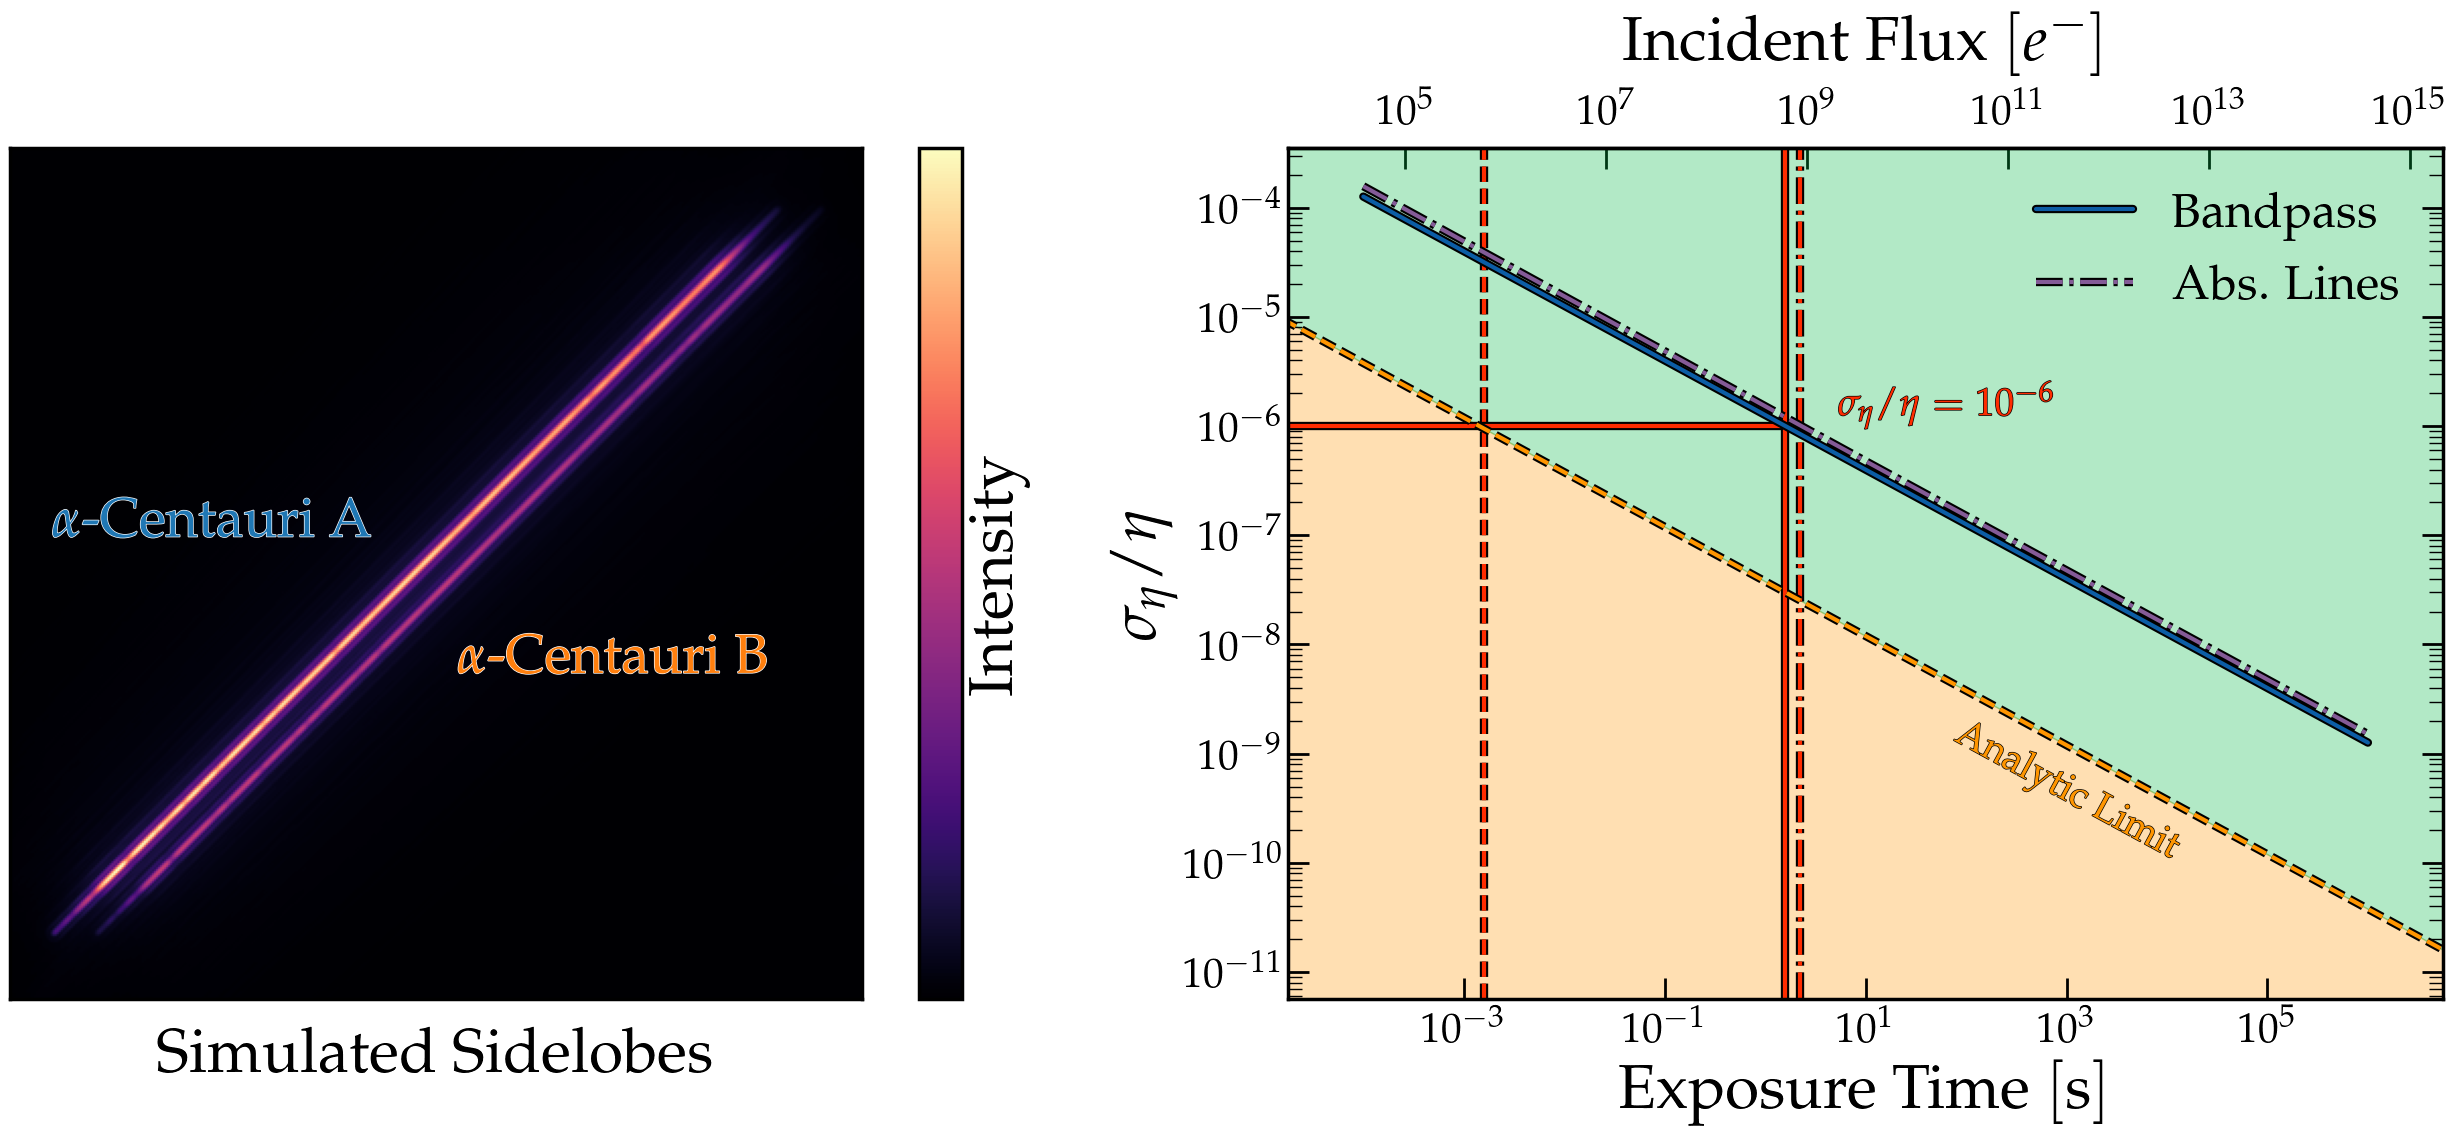

In [ ]:
# doing double plot with the sidelobes
path_effects_white = [pe.Stroke(linewidth=1, foreground='white'), pe.Normal()]

fig = plt.figure(figsize=(26,12))
ax = fig.add_subplot(1,2,1)
im = ax.imshow(sidelobe_safe**0.5, cmap='magma', origin='lower')
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([])
cbar.set_label('Intensity')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Simulated Sidelobes', labelpad=20)

# adding text
ax.text(20, 220, r'$\alpha$-Centauri A',
        color='tab:blue', fontsize=40, ha='left', va='bottom',path_effects=path_effects_white)

ax.text(220, 180, r'$\alpha$-Centauri B',
        color='tab:orange', fontsize=40, ha='left', va='top',path_effects=path_effects_white),

ax2 = fig.add_subplot(1,2,2)

ax2.axvline(10**(0.2), ymax=1, path_effects=path_effects, color='C3')
ax2.axvline(10**(0.35), ymax=1, path_effects=path_effects, color='C3', ls='-.')

ax2.axvline(10**(-2.8), ymax=1, path_effects=path_effects, color='C3', ls='--')
ax2.axhline(1e-6, xmax=0.427, path_effects=path_effects, color='C3')


ax2.plot(exposure_times, np.sqrt(covs_array)/psf_pixel_scale, path_effects=path_effects, label='Bandpass')
ax2.plot(exposure_times, np.sqrt(covs_nobl_array)/psf_pixel_scale, path_effects=path_effects, label='Abs. Lines', ls='-.', color='C4')
ax2.plot(more_exp_times, analytic_pscale_stdev, color='C2', ls='--', path_effects=path_effects)
#plt.plot(exposure_times, np.sqrt(covs_total_array)/psf_pixel_scale)

ax2.fill_between(more_exp_times, analytic_pscale_stdev, alpha=0.3, color='C2')
ax2.fill_between(more_exp_times, analytic_pscale_stdev, 10**(-3),alpha=0.3, color='C1')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Exposure Time $[\mathrm{s}]$')
ax2.set_ylabel(r'$\sigma_\eta/\eta$')
ax2.set_xlim(10**(-4.75),10**(6.75))
ax2.set_ylim(10**(-11.25),10**(-3.45))
#plt.xticks(minor=True)
ax2.legend()

def photons(exptime):
    ph = exptime*totalFlux
    return ph

def exptime(photons):
    et = photons/totalFlux
    return et

ax2.tick_params(
    axis='x',
    which='both',
    top=False,
)

secax = ax2.secondary_xaxis('top', functions=(photons,exptime))
secax.set_xlabel(r'Incident Flux $[e^-]$',labelpad=25)

ax2.annotate(r'$\sigma_\eta/\eta = 10^{-6}$',
            xy=(10**(1.8), 10**(-5.9)), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C3',
            ha='center',
            path_effects=text_path_effects)


ax2.annotate(r'Analytic Limit',
            xy=(10**(3), 10**(-9.95)), #-0.005),
            #xytext=(0.348, 0.5),   # text location in data coords (tweak as desired)
            color='C2',
            ha='center',
            rotation=-28.5,
            path_effects=text_path_effects)



plt.tight_layout()

#plt.savefig('sidelobepscal.pdf',dpi=300,bbox_inches='tight')
plt.show()